In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import r2_score
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.api as sm


%matplotlib inline
warnings.filterwarnings('ignore')
import platform
plt.rcParams['font.family'] = 'NanumGothic' 
matplotlib.rcParams['axes.unicode_minus'] = False

# 전체 과정
1. 도메인 정보 파악
2. 전처리
3. EDA
4. 모델링
5. 핵심 인자 도출
6. 경쟁력 확보 방안 도출

# 1. 도메인 정보 파악 
- 배경 : 인도 중고차 시장의 성장 -> 중고차 가격을 효과적으로 예측할 수 있는 핵심영향인자 도출 + 가격 예측 모델 개발
- 기본 가정 : 인도 중고차 시장은 가성비 좋은 차량을 선호한다.
    1) (Engine) 엔진 배기량이 높을수록 자동차 성능이 좋다(상대적으로 큰 차량이다) -> 가격이 높다.
    2) (Power) 엔진 출력이 높을수록 자동차 성능이 좋다 -> 가격이 높다.
    3) (Mileage) 연비가 높을수록 자동차 성능이 좋다 -> 가격이 높다.
    4) (Kilometers_Driven) 주행거리가 낮을 수록 자동차 성능이 좋다 -> 가격이 높다.
    5) (Year) 출고년도가 높을 수록(최신이다) 자동차 성능이 좋다 -> 가격이 높다.
    6) (Seats) 좌석수가 많을 수록 자동차 성능이 좋다(큰 차량이다) -> 가격이 높다.
    7) (Owner_Type) 첫번째 중고차일수록 자동차 성능이 좋다 -> 가격이 높다.
- 도메인 지식을 활용한 추가 가정
    1) (Transmission) 인도는 도로 상황이 좋지 않고, 가격이 저렴한 수동 차량을 선호한다. 수동 차량이 가격이 낮다.
    2) (Location) Delhi, Mumbai, Chennai, Kolkata, Hyderabad 5개 도시는 인프라, 수요 조건(인구, 소득 조건), 기업 경쟁력(다양성)을 기준으로 조사를 해보았을 때 인도에서 잘사는 도시로 판단된다. 따라서 상대적으로 가격이 비싼 차량이 많이 팔릴 것으로 예상된다.
    3) (Brand) 브랜드는 가성비가 좋은 인도 회사인 Maruti가 전체적으로 가장 많이 선호될 것으로 예상된다.
    4) (Fuel_Type) 연비가 좋은 디젤(경유), 패트롤(가솔린) 차량이 선호될 것으로 예상된다.

# 2. 데이터 전처리
1) 데이터 불러오기 / 요약정보 파악
2) 결측치 처리
3) 이상치 처리
4) 컬럼 특성 파악 및 전처리
    - Name
    - Location
    - Price
    - Year
    - Kilometers_driven
    - Fuel_Type
    - Owner_Type
    - Mileage
    - Engine
    - Power
    - Seats

In [2]:
# 1) 데이터 불러오기
df = pd.read_csv('Car.csv')
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [3]:
# 요약정보
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 736.8+ KB


### 데이터 설명
* 목표변수
    - Price 중고차 가격(단위 : 1,000원)
* 설명변수
   - Name : 자동차 브랜드와 모델의 이름
   - Location : 자동차를 팔거나 구매할 수 있는 위치
   - Year : 모델의 년도 혹은 버전
   - Kilometers_Driven : 이전 소유주의 차량 주행거리(Km)
   - Fuel_Type : 자동차의 사용연료의 종류
   - Transmission : 자동차의 사용 변속기 종류(Manual/Automatic)
   - Owner_Type : 소유권이 직접 소유인지, 중고 소유인지 여부
   - Mileage : 자동차 회사가 제공하는 표준주행거리(kmpl)
   - Engine : 엔진의 배기량(cc)
   - Power : 엔진의 최대 출력(bhp)
   - Seats : 차의 좌석 수
   - New_Price : 뉴 모델의 가격

In [4]:
df.describe() # 수치형 변수 기술통계량

,Price,Year,Kilometers_Driven,Seats
count,6200.000000,7253.000000,7.253000e+03,7200.000000
mean,14912.514750,2013.365366,5.869906e+04,5.279722
std,17674.318464,3.254421,8.442772e+04,0.811660
min,7.080000,1996.000000,1.710000e+02,0.000000
25%,5365.360000,2011.000000,3.400000e+04,5.000000
50%,8814.520000,2014.000000,5.341600e+04,5.000000
75%,15869.972500,2016.000000,7.300000e+04,5.000000
max,245273.600000,2019.000000,6.500000e+06,10.000000


### 결측치

In [5]:
# 결측치 확인
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
dtype: int64

- New_Price : 결측치가 6247개로 전체 7253개 중 약 86.1%로 큰 비중을 차지하고, 열 특성 자체가 가격 예측에 영향을 주지 않을 것이라 판단되어 열 자체 제거
- Mileage, Engine, Power, Seats : 결측치의 개수가 적어 결측치가 예측에 큰 영향을 주지 않을 것이라 판단되어 결측치에 해당하는 행만 제거
- Price : 1053개의 결측치가 존재하지만, 목표변수에 해당하므로 따로 보간하지 않고 결측치 존재 행 제거

In [6]:
# Price 결측치 제거
df.dropna(subset=['Price'], inplace=True)
df[df['Price'].isna()]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price


In [7]:
# New_Price 컬럼 제거
df.drop('New_Price',axis=1,inplace=True)

In [8]:
# Mileage / Engine / Power / Seats 결측치 제거
df.dropna(subset=['Mileage','Engine','Power','Seats'],axis=0,inplace=True)

### 이상치

In [9]:
# Power 열 null bhp 제거
# 수치상 null은 이상치로 판단하고 제거
df[df['Power'] == 'null bhp'] 
df = df[df['Power'] != 'null bhp'] # 제거

<Axes: >

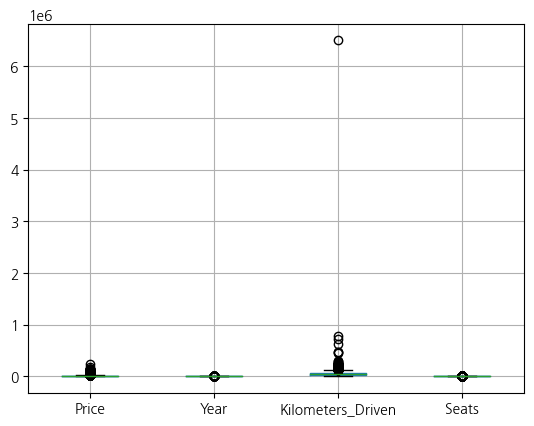

In [10]:
df.boxplot()

- Kilometers_Driven에서 이상치로 판단되는 값이 하나 확인됨.
- 이외에 아직 이상치 판단하기 어려움이 있어 데이터 파악 후 추후 처리 진행 예정.

### 단위제거 및 형변환
- 단위 들어가 있는 컬럼 단위 제거 후 수치형으로 변환
- ex. Mileage : 17.8 kmpl -> 17.8

In [11]:
df['Mileage'] = df['Mileage'].str.replace('kmpl','').astype('float')
df['Engine'] = df['Engine'].str.replace('CC','').astype('float')
df['Power'] = df['Power'].str.replace('bhp','').astype('float')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6053 entries, 0 to 7236
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6053 non-null   object 
 1   Location           6053 non-null   object 
 2   Price              6053 non-null   float64
 3   Year               6053 non-null   int64  
 4   Kilometers_Driven  6053 non-null   int64  
 5   Fuel_Type          6053 non-null   object 
 6   Transmission       6053 non-null   object 
 7   Owner_Type         6053 non-null   object 
 8   Mileage            6053 non-null   float64
 9   Engine             6053 non-null   float64
 10  Power              6053 non-null   float64
 11  Seats              6053 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 614.8+ KB


### 파생변수 생성

In [13]:
df.Name.nunique()
# Name의 unique의 개수가 너무 많아 분석 및 판단에 이상이 있을 것이라 생각됨.
# Name에서 Brand명만 구분하여 사용하는 Brand 파생변수 생성

1856

In [14]:
# Name열 split 후 회사명(브랜드)만 리턴하는 함수
def extract_brand(text):
    return text.split()[0]

In [15]:
df['Brand'] = df['Name'].apply(extract_brand)
df['Brand'].head()

0     Maruti
1    Hyundai
2      Honda
3     Maruti
4       Audi
Name: Brand, dtype: object

In [16]:
# Name 변수 제거
df.drop('Name',axis=1,inplace=True)

In [17]:
df.Brand.nunique()

29

In [18]:
df['Brand'].value_counts().sum()

6053

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 [Text(0, 0, 'Maruti'),
  Text(1, 0, 'Hyundai'),
  Text(2, 0, 'Honda'),
  Text(3, 0, 'Audi'),
  Text(4, 0, 'Nissan'),
  Text(5, 0, 'Toyota'),
  Text(6, 0, 'Volkswagen'),
  Text(7, 0, 'Tata'),
  Text(8, 0, 'Land'),
  Text(9, 0, 'Mitsubishi'),
  Text(10, 0, 'Renault'),
  Text(11, 0, 'Mercedes-Benz'),
  Text(12, 0, 'BMW'),
  Text(13, 0, 'Mahindra'),
  Text(14, 0, 'Ford'),
  Text(15, 0, 'Porsche'),
  Text(16, 0, 'Datsun'),
  Text(17, 0, 'Jaguar'),
  Text(18, 0, 'Volvo'),
  Text(19, 0, 'Chevrolet'),
  Text(20, 0, 'Skoda'),
  Text(21, 0, 'Mini'),
  Text(22, 0, 'Fiat'),
  Text(23, 0, 'Jeep'),
  Text(24, 0, 'Ambassador'),
  Text(25, 0, 'ISUZU'),
  Text(26, 0, 'Force'),
  Text(27, 0, 'Bentley'),
  Text(28, 0, 'Lamborghini')])

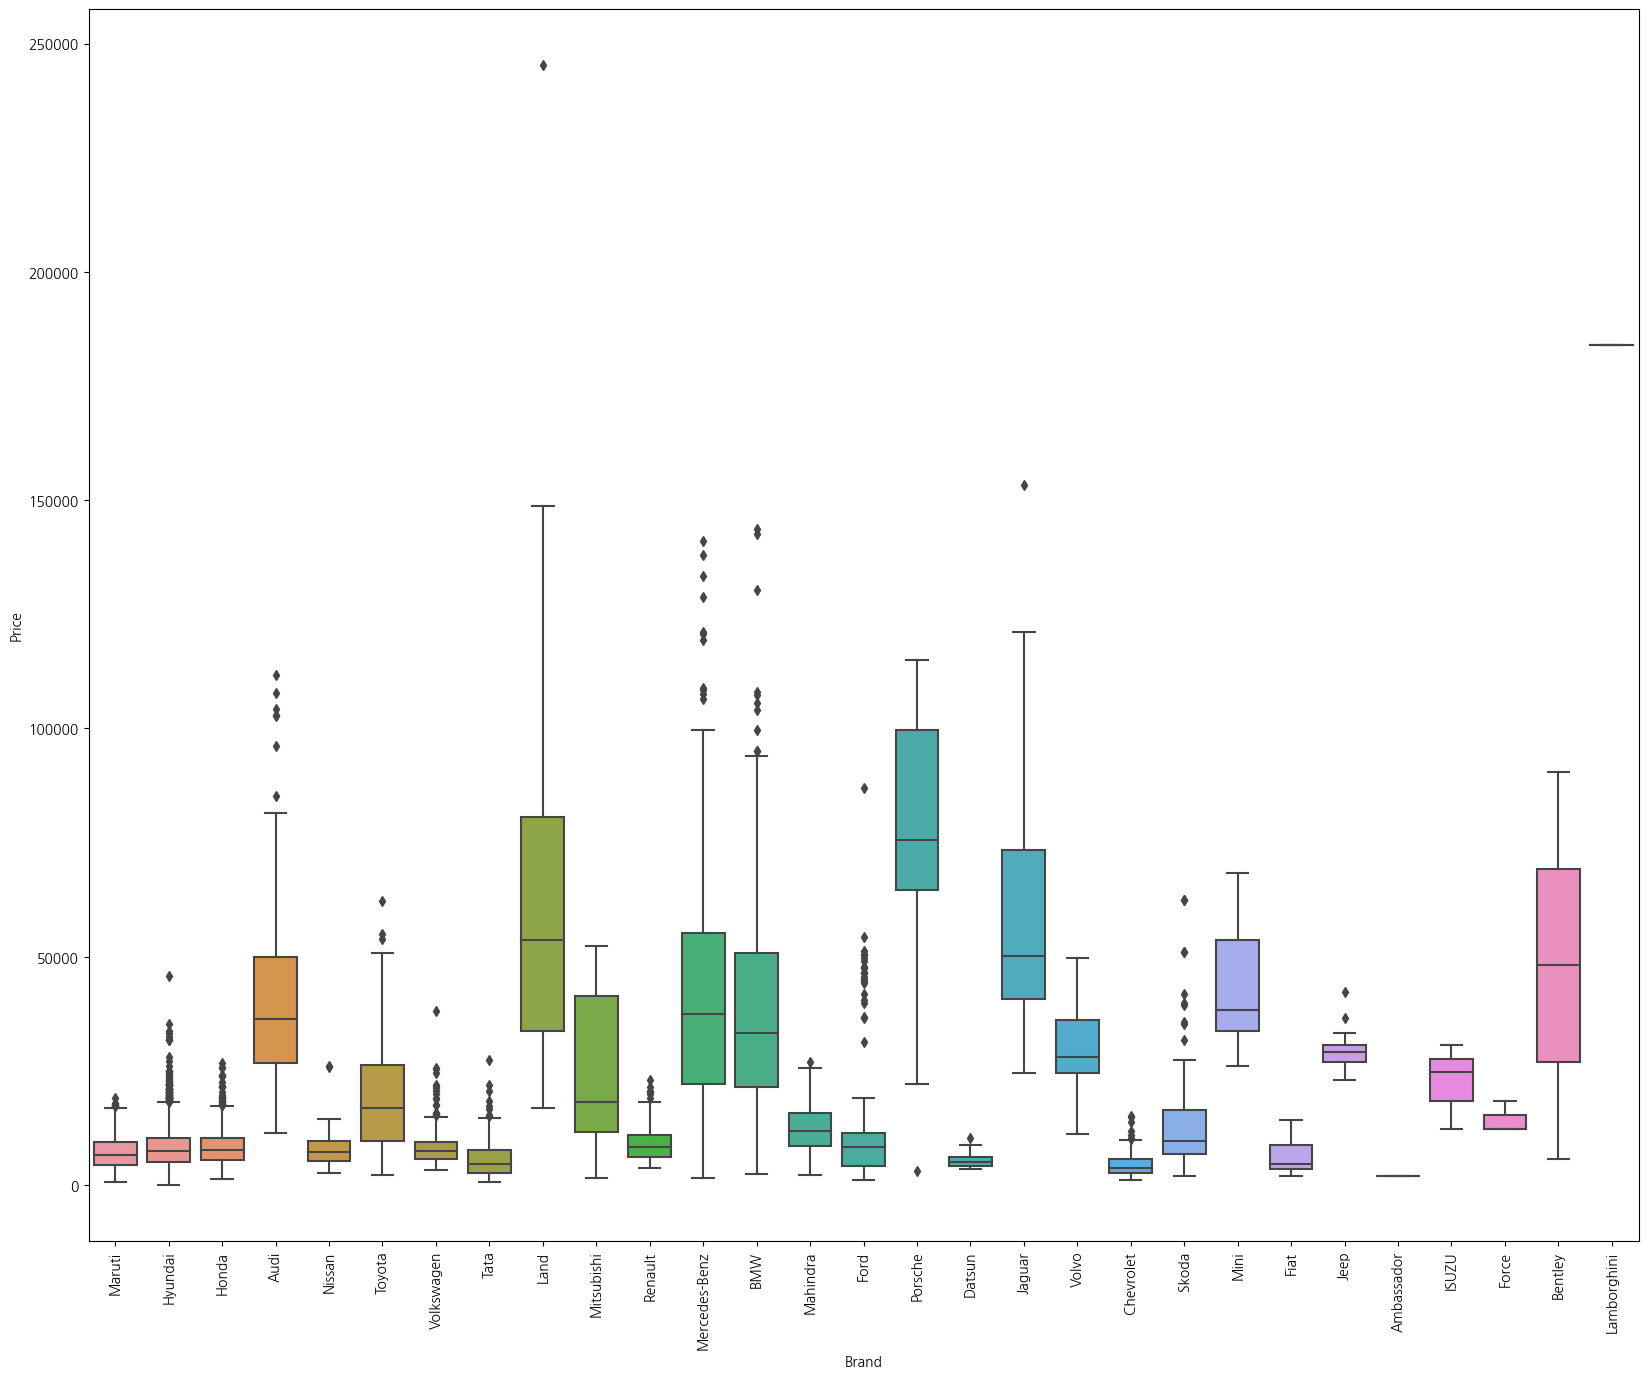

In [19]:
plt.figure(figsize=(20,16))
sns.boxplot(x='Brand',y='Price',data=df)
plt.xticks(rotation=90)

In [20]:
# Brand에서도 10개 이하로 분포하는 브랜드는 분석에 영향이 없을 것이라 판단하여 제거
# 한자리 수 차량 5개 제거 시작
brand_counts = df['Brand'].value_counts()
brand_counts

Maruti           1218
Hyundai          1079
Honda             614
Toyota            406
Mercedes-Benz     323
Volkswagen        320
Ford              298
Mahindra          278
BMW               268
Audi              240
Tata              192
Skoda             181
Renault           151
Chevrolet         120
Nissan             93
Land               57
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               26
Volvo              21
Jeep               19
Datsun             17
Porsche            16
ISUZU               3
Force               3
Bentley             2
Ambassador          1
Lamborghini         1
Name: Brand, dtype: int64

In [21]:
# 브랜드 행을 brand_count로 map하고 행 추가
df['Brand_count'] = df['Brand'].map(brand_counts)
df.head()

,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Brand_count
0,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,1218
1,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,1079
2,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,614
3,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,1218
4,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,240


In [22]:
# brand_count 행에서 10개 미만이 있는지 query 함수로 필터링
filtered_df = df.query("Brand_count < 10")
print(filtered_df)

        Location      Price  Year  Kilometers_Driven Fuel_Type Transmission  \
1221     Chennai    2069.50  2003              80000    Diesel       Manual   
2900      Jaipur   30659.20  2017              34429    Diesel    Automatic   
3624  Coimbatore   24665.33  2018              20422    Diesel       Manual   
4997     Chennai   18395.52  2014              50000    Diesel       Manual   
5182     Kolkata   12263.68  2014              41000    Diesel       Manual   
5206     Kolkata   12263.68  2014              41000    Diesel       Manual   
5521   Hyderabad   90444.64  2006              48000    Petrol    Automatic   
5781       Delhi  183955.20  2011               6500    Petrol    Automatic   
5979      Jaipur   12263.68  2017              25000    Diesel       Manual   
6354   Bangalore    5748.60  2008              31200    Petrol    Automatic   

     Owner_Type  Mileage  Engine   Power  Seats        Brand  Brand_count  
1221      Third     12.8  1489.0   35.50    5.0   Amba

In [23]:
# brand_count 수가 10개 미만인 열을 제거함
index_to_drop = df[df['Brand_count'] < 10].index
df.drop(index_to_drop, inplace=True)
print(df)

        Location     Price  Year  Kilometers_Driven Fuel_Type Transmission  \
0         Mumbai   2682.68  2010              72000       CNG       Manual   
1           Pune  19162.00  2015              41000    Diesel       Manual   
2        Chennai   6898.32  2011              46000    Petrol       Manual   
3        Chennai   9197.76  2012              87000    Diesel       Manual   
4     Coimbatore  27194.71  2013              40670    Diesel    Automatic   
...          ...       ...   ...                ...       ...          ...   
7228        Pune  10822.70  2016              41413    Diesel       Manual   
7231       Kochi  13474.72  2017              39015    Petrol       Manual   
7232      Mumbai  27838.55  2018               6000    Petrol       Manual   
7235       Kochi  16203.39  2017              21380    Diesel       Manual   
7236       Kochi      7.08  2018              23955    Petrol       Manual   

     Owner_Type  Mileage  Engine   Power  Seats    Brand  Brand

In [24]:
# 조건 필터링으로 제거된지 확인 / 결과 empty
filtered_df = df.query("Brand_count < 10")
print(filtered_df)

Empty DataFrame
Columns: [Location, Price, Year, Kilometers_Driven, Fuel_Type, Transmission, Owner_Type, Mileage, Engine, Power, Seats, Brand, Brand_count]
Index: []


In [25]:
# 다 사용한 brand_count는 필요없으므로 컬럼 제거
df.drop('Brand_count',axis=1,inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'Maruti'),
  Text(1, 0, 'Hyundai'),
  Text(2, 0, 'Honda'),
  Text(3, 0, 'Audi'),
  Text(4, 0, 'Nissan'),
  Text(5, 0, 'Toyota'),
  Text(6, 0, 'Volkswagen'),
  Text(7, 0, 'Tata'),
  Text(8, 0, 'Land'),
  Text(9, 0, 'Mitsubishi'),
  Text(10, 0, 'Renault'),
  Text(11, 0, 'Mercedes-Benz'),
  Text(12, 0, 'BMW'),
  Text(13, 0, 'Mahindra'),
  Text(14, 0, 'Ford'),
  Text(15, 0, 'Porsche'),
  Text(16, 0, 'Datsun'),
  Text(17, 0, 'Jaguar'),
  Text(18, 0, 'Volvo'),
  Text(19, 0, 'Chevrolet'),
  Text(20, 0, 'Skoda'),
  Text(21, 0, 'Mini'),
  Text(22, 0, 'Fiat'),
  Text(23, 0, 'Jeep')])

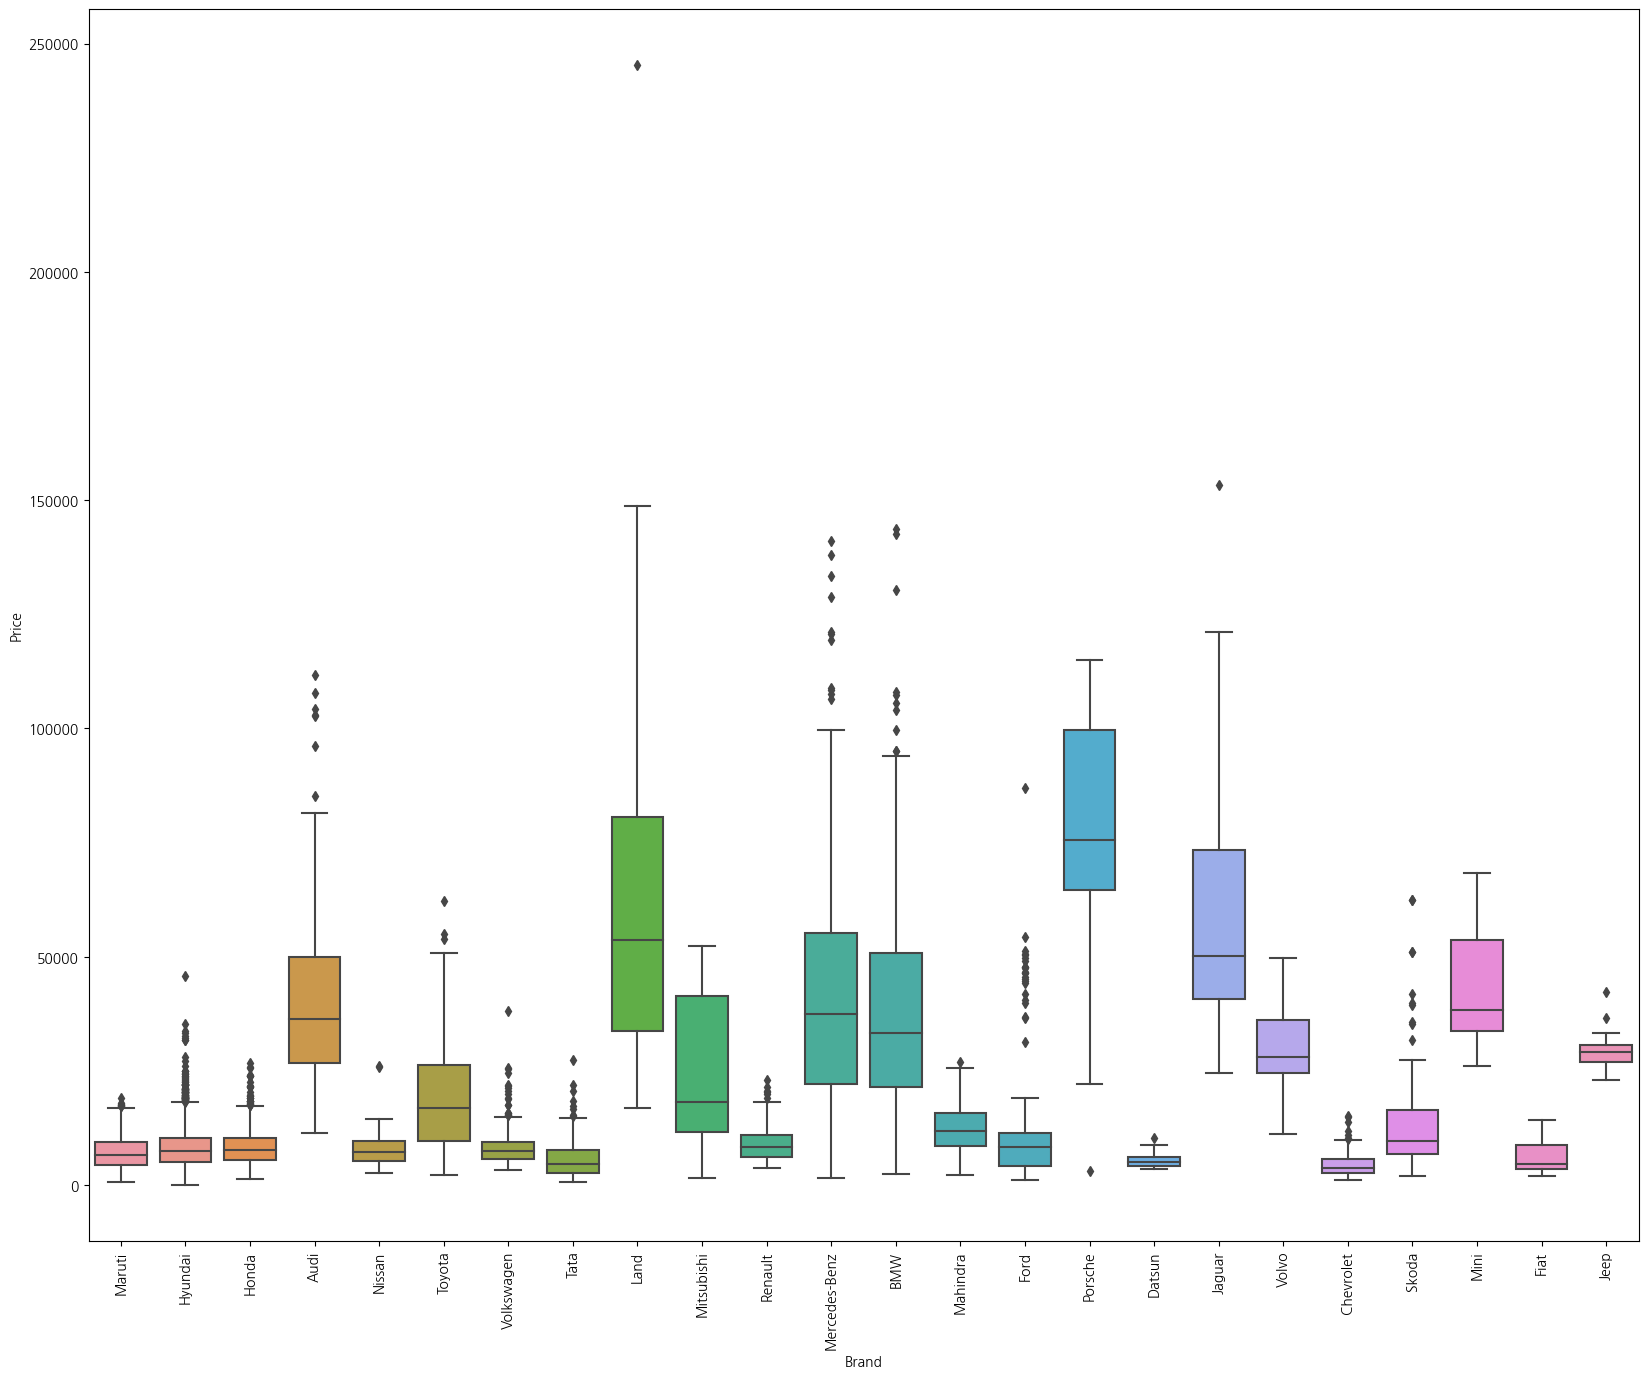

In [26]:
plt.figure(figsize=(20,16))
sns.boxplot(x='Brand',y='Price',data=df)
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Seats')

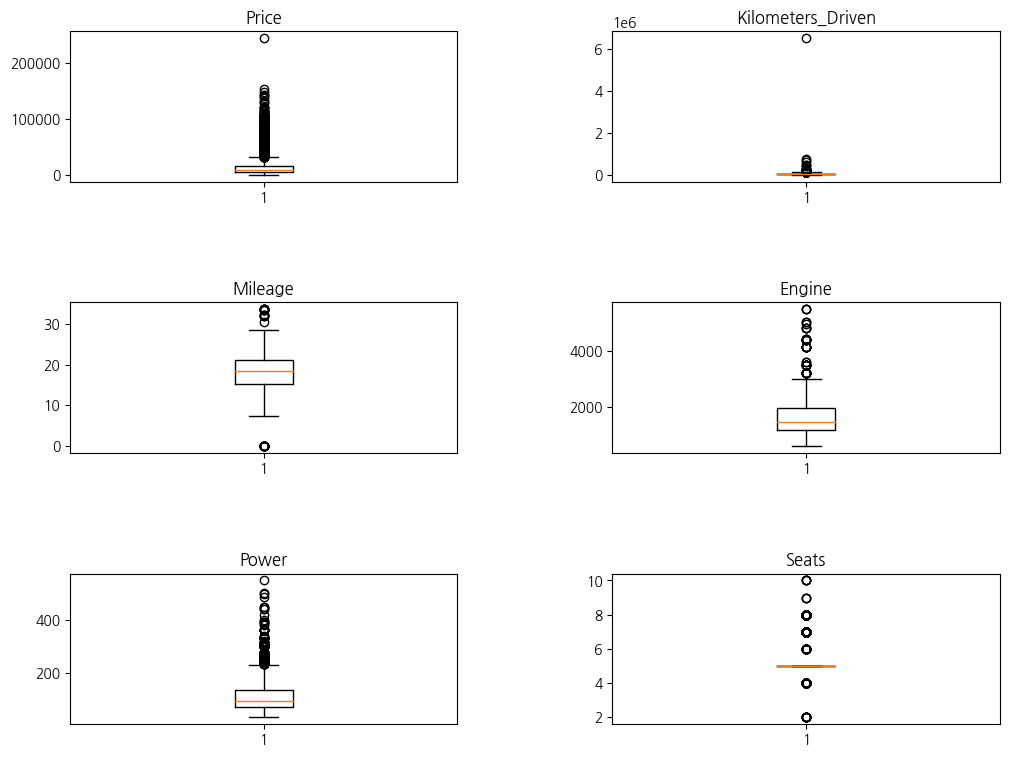

In [27]:
#이상치 재확인을 위한 box-plot
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()

fig.subplots_adjust(wspace=0.4, hspace=0.8)

axs[0].boxplot(df['Price'])
axs[0].set_title('Price')

axs[1].boxplot(df['Kilometers_Driven'])
axs[1].set_title('Kilometers_Driven')

axs[2].boxplot(df['Mileage'])
axs[2].set_title('Mileage')

axs[3].boxplot(df['Engine'])
axs[3].set_title('Engine')

axs[4].boxplot(df['Power'])
axs[4].set_title('Power')

axs[5].boxplot(df['Seats'])
axs[5].set_title('Seats')

- Price, Power 열의 이상치가 많이 분포한다고 판단되어 따로 확인

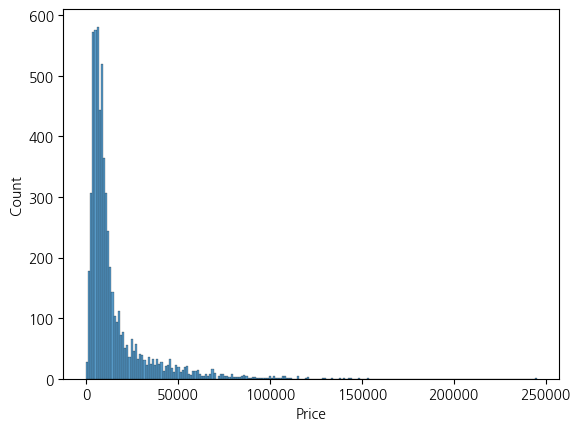

In [28]:
sns.histplot(df['Price'])
plt.show()

- 대부분이 50000 이하에 분포한다.
- 그래프가 정규성을 띄지 않는다 판단하여 정규분포를 띄도록 로그 변환 진행 후 새로운 파생 변수로 저장 + 기존 Price 컬럼 삭제

In [29]:
df['Price_log']=np.log(df['Price'])
df.drop("Price", axis=1, inplace=True)

<Axes: xlabel='Price_log', ylabel='Count'>

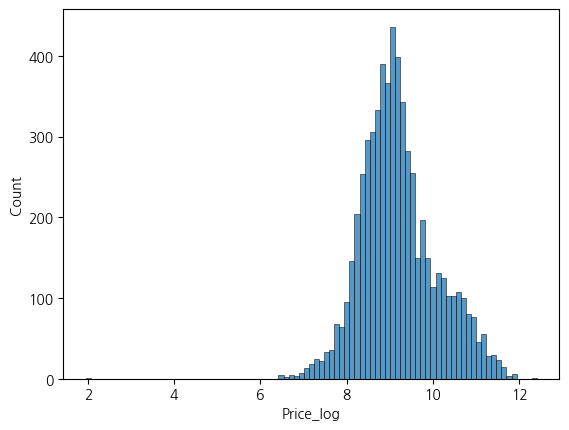

In [30]:
# 재확인
sns.histplot(df['Price_log'])

- 로그 변환을 통해 비대칭 분포를 보다 정규 분포의 형태에 가깝게 변형

<Axes: xlabel='Power', ylabel='Count'>

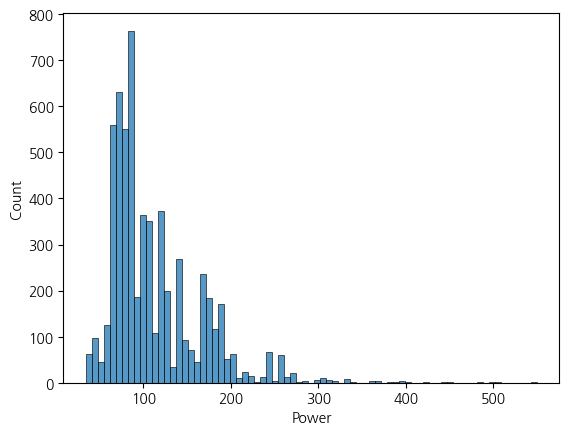

In [31]:
sns.histplot(df['Power'])

- 마찬가지로 정규분포의 형태로 띄게 하기 위해 로그 변환

In [32]:
df['Power_log']=np.log(df['Power'])
df.drop("Power", axis=1, inplace=True)

<Axes: xlabel='Power_log', ylabel='Count'>

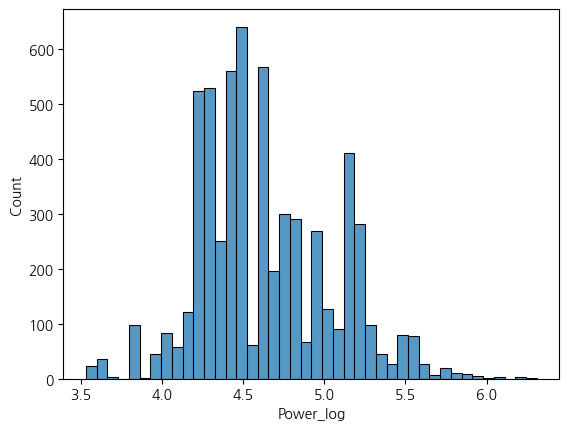

In [33]:
sns.histplot(df['Power_log'])

- 좀 더 정규분포에 가깝게 변형됨.

In [34]:
# 이상치 재확인
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Seats,Price_log,Power_log
count,6043.000000,6.043000e+03,6043.000000,6043.000000,6043.000000,6043.000000,6043.000000
mean,2013.554195,5.776755e+04,18.332421,1621.504054,5.283138,9.198489,4.637033
std,3.163403,9.102873e+04,4.361214,594.607094,0.802857,0.874527,0.414794
min,1998.000000,1.710000e+02,0.000000,624.000000,2.000000,1.957274,3.532226
25%,2012.000000,3.282950e+04,15.290000,1198.000000,5.000000,8.615890,4.317488
50%,2014.000000,5.200000e+04,18.490000,1495.000000,5.000000,9.092814,4.550503
75%,2016.000000,7.200000e+04,21.120000,1984.000000,5.000000,9.686331,4.927978
max,2019.000000,6.500000e+06,33.540000,5461.000000,10.000000,12.410130,6.309918


In [35]:
# Kilometers_Driven max 값이 약 300만 키로로 이상치로 판단됨 -> 7개
# 앞서 boxplot으로 이상치 존재 확인
df = df[df['Kilometers_Driven'] < 300000]

In [36]:
# Mileage 열에서 min값이 0으로 이상치로 판단됨 -> 먼저 확인
# 데이터 수가 분석에 큰 영향을 주지 않을 것이라 판단하고 제거
df[df['Mileage'] == 0]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Price_log,Power_log
14,Pune,2012,85000,Diesel,Automatic,Second,0.0,2179.0,5.0,Land,10.197157,4.744932
67,Coimbatore,2019,15369,Diesel,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,10.909266,5.267858
544,Kochi,2019,13190,Petrol,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,10.998261,5.200870
707,Pune,2014,120000,Diesel,Automatic,First,0.0,2987.0,5.0,Mercedes-Benz,10.736153,5.105945
962,Mumbai,2018,8682,Diesel,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,11.011256,5.267858
996,Pune,2008,93000,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,7.706518,4.127134
1059,Hyderabad,2010,58163,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,8.231043,4.127134
1259,Bangalore,2010,125000,Diesel,Automatic,Second,0.0,2179.0,5.0,Land,9.732851,4.744932
1308,Bangalore,2014,33000,Diesel,Automatic,Second,0.0,2987.0,5.0,Mercedes-Benz,11.096156,5.105945
1354,Kochi,2011,20842,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,8.357407,4.127134


In [37]:
df=df[df['Mileage']!=0]

In [38]:
df[df['Mileage'] == 0] # 제거 확인

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Price_log,Power_log


In [39]:
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Seats,Price_log,Power_log
count,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000
mean,2013.558682,56133.620110,18.417977,1618.510571,5.284834,9.195398,4.635905
std,3.162622,33337.759375,4.190076,591.982276,0.804960,0.870709,0.414242
min,1998.000000,171.000000,7.500000,624.000000,2.000000,1.957274,3.532226
25%,2012.000000,32829.500000,15.350000,1198.000000,5.000000,8.615890,4.317488
50%,2014.000000,52000.000000,18.500000,1493.000000,5.000000,9.092814,4.543295
75%,2016.000000,72000.000000,21.140000,1969.000000,5.000000,9.682036,4.927978
max,2019.000000,299322.000000,33.540000,5461.000000,10.000000,12.410130,6.309918


# 3. EDA

## 도메인 지식을 바탕으로 EDA 진행

### 1) GDP가 높은 지역에서 중고차 거래 금액이 높다.

In [40]:
df['Location'].unique()

array(['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad'],
      dtype=object)

@ Hyderabad / Mumbai / Delhi / Kolkata / Chennai -> 가장 GDP 높은 도시 5개

@ Coimbatore -> 중산층이 많고 중산층에서 중고차 수요 높음

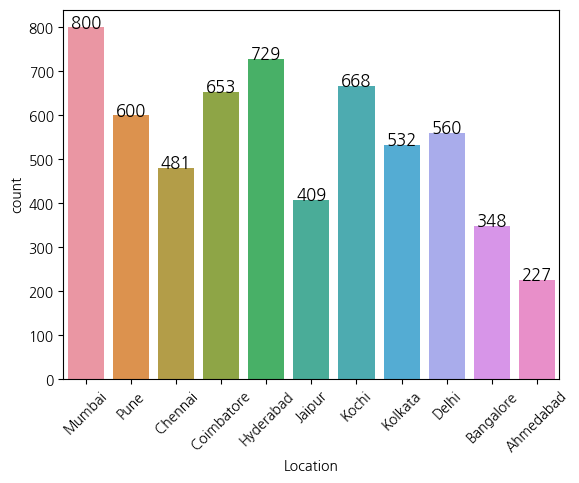

In [41]:
sns.countplot(df,x='Location')
plt.xticks(rotation=45)
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width() / 2, 
                   p.get_height() + 0.2, 
                   int(p.get_height()), 
                   ha='center', 
                   fontsize=12)
plt.show()

- Mumbai : 800
- Hyderabad : 729
- Delhi : 560 
- Kolkata : 534
- Chennai : 484

Coimbatore : 가장 큰 도시는 아니지만 중산층 사이에서 중고차에 대한 수요가 높아 상당한 양의 판매량을 보인다.

In [42]:
(729 + 800 + 560 + 534 + 484) / 6013 # 다섯개 도시에서 구매 및 판매 -> 전체 51.7%에 해당

0.5167137867952769

In [44]:
a = df.groupby('Location')['Price_log'].agg('mean')

In [45]:
loc_price = pd.DataFrame(a)
loc_price.sort_values(by='Price_log',ascending=False)

,Price_log
Location,
Coimbatore,9.689098
Bangalore,9.521465
Kochi,9.411207
Mumbai,9.242791
Hyderabad,9.231757
Delhi,9.231625
Ahmedabad,9.199281
Chennai,8.983619
Pune,8.894057


- 중고차 거래 평균 금액이 가장 높은 지역은 Coimbatore로 나타났다.

In [46]:
loc_price.reset_index(inplace=True,drop=True)

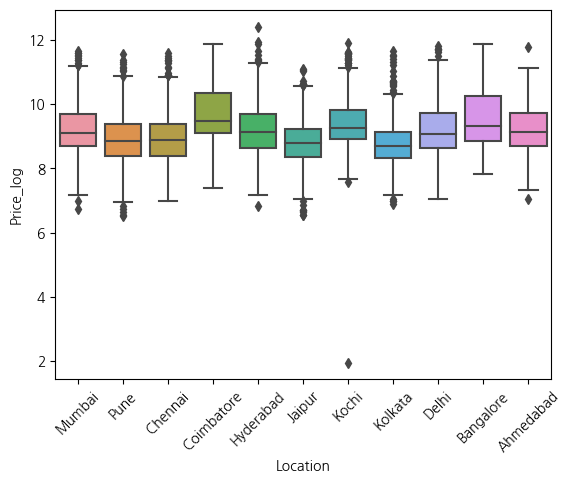

In [47]:
sns.boxplot(x='Location',y='Price_log',data=df)
plt.xticks(rotation=45)
plt.show()

1. Coimbatore : 가장 높은 중간 가격으로 두드러지며, 여기에서 판매되는 자동차는 일반적으로 다른 도시에 비해 더 비싸다

2.  Hyderabad / Mumbai / Delhi : 자동차 가격이 다양하지만, 중간 가격은 Coimbatore보다 상대적으로 낮다. 이는 다양한 자동차 유형에 대한 수요가 더 높음을 나타낸다.

3. Kolkata / Chennai : 중간 가격이 낮은데, 이는 이 도시의 시장이 가격에 더 민감하며, 저렴한 차량에 중점을 둔다는 것을 보여준다.

- 부유한 도시(Hyderabad / Mumbai / Delhi / Kolkata / Chennai)가 전체 시장에 상당히 기여하고 있으며, 전체 판매량의 51.7%를 차지한다는 것을 보여준다. 이는 부유한 도시가 시장에 상당한 영향을 미친다고 생각할 수 있지만, 가격 분포는 더 복잡하여 이러한 도시에서 판매되는 모든 자동차가 고급은 아니라는 것을 나타낸다.
- Coimbatore와 같은 중산층 도시는 고가의 중고차에 투자할 의향이 상당히 있어 이 부문에서 수요가 강함을 나타낸다. 
- Kolkata / Chennai는 중간 가격이 낮아 이 지역의 소비자가 가격에 더 민감하고 더 저렴한 차량을 선호할 수 있음을 나타낸다. 

In [48]:
brand_count_by_location = df.groupby(['Location', 'Brand']).size().reset_index(name='Count')
top_brands_by_location = brand_count_by_location.loc[brand_count_by_location.groupby('Location')['Count'].idxmax()]
brand_count_by_location = df.groupby(['Location', 'Brand']).size().reset_index(name='Count')
top_3_brands_by_location = brand_count_by_location.groupby('Location').apply(
    lambda x: x.nlargest(3, 'Count')
)
top_3_brands_by_location.drop('Location',axis=1,inplace=True)
top_3_brands_by_location

Brand  Count
Location                            
Ahmedabad  8           Maruti     53
           5          Hyundai     47
           4            Honda     26
Bangalore  25         Hyundai     76
           19            Audi     32
           30   Mercedes-Benz     32
Chennai    52          Maruti     97
           48         Hyundai     71
           46            Ford     46
Coimbatore 70         Hyundai    134
           75          Maruti     96
           63            Audi     52
Delhi      98          Maruti    119
           93         Hyundai     89
           107         Toyota     66
Hyderabad  122         Maruti    174
           117        Hyundai    103
           131         Toyota     58
Jaipur     144         Maruti    114
           141        Hyundai     86
           140          Honda     38
Kochi      161        Hyundai    140
           166         Maruti    126
           160          Honda     83
Kolkata    189         Maruti    115
           185        Hyundai    114
           184          Honda     72
Mumbai     212         Maruti    146
           207        Hyundai    114
           206          Honda    108
Pune       236         Maruti    148
           231        Hyundai     96
           230          Honda     62

1. 대부분의 도시에서 Maruti와 Hyundai가 상위 브랜드로 선정되었다. 이는 이들 브랜드가 인도 시장에서 대중적이며 신뢰받는 브랜드임을 나타낸다.
2. Bangalore와 Coimbatore에서 Audi와 Mercedes-Benz 같은 고급 브랜드가 상위 3위 안에 들었습니다. 이는 이 도시들에서 고급 차량에 대한 수요가 존재함을 의미한다.


- 잘 사는 도시들에서는 비싼 차가 많이 팔릴 것으로 예상했으나, 실제로는 그렇지 않았으며, 다양한 가격대의 중고차가 고르게 소비되고 있다. 이는 인도 시장이 매우 다양한 소비자층을 보유하고 있으며, 차량 선택이 단순히 경제적 부유함에만 의존하지 않는다는 것을 보여준다.
- 반면 Coimbatore와 같은 중산층 중심의 도시는 평균 중고차 가격이 상대적으로 높다는 점에서, 이들 도시에서의 중고차 시장이 더욱 고급화되고 있음을 나타낸다.
- 브랜드 선호도가 도시별로 다르게 나타나는 것은 각 도시의 경제적, 문화적 배경에 따라 차량 구매 패턴이 달라질 수 있음을 보여준다.


### 2) 인도에선 수동차를 선호될 것이다.

- 수동차량이 더 저렴할 것인가

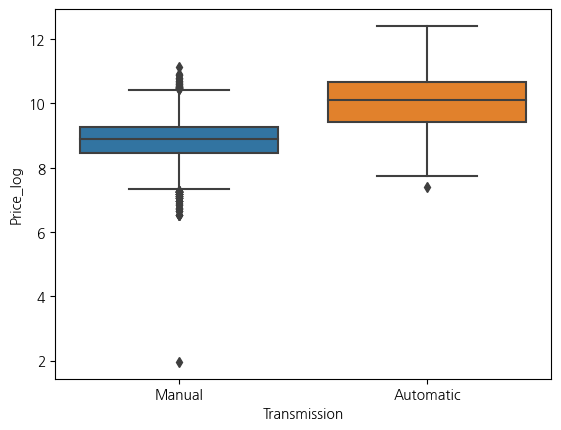

In [50]:
sns.boxplot(data=df, x='Transmission', y='Price_log')
plt.show()

In [52]:
df.groupby('Transmission')['Price_log'].mean()

Transmission
Automatic    10.025044
Manual        8.857632
Name: Price_log, dtype: float64

- 수동 차량(Manual)이 자동 차량(Automatic)보다 전반적으로 더 저렴한 것으로 나타났다.
- 수동 차량의 가격 범위는 상대적으로 좁고, 중앙값도 낮다. 반면 자동 차량은 더 넓은 가격 분포를 보이며, 특히 고가의 차량들도 포함된 것을 알 수 있다.
- 이는 수동 차량이 자동 차량에 비해 더 경제적이라는 사실을 나타내며, 비용을 중시하는 소비자들에게 수동 차량이 더 매력적일 수 있다고 예상한다.
- Automatic 차량에서 가격이 확연히 비싼 데이터가 관측되어 평균에서 큰 차이를 보이나, Manual 차량이 Automatic 차량보다 저렴하다고 판단할 수 있었다.

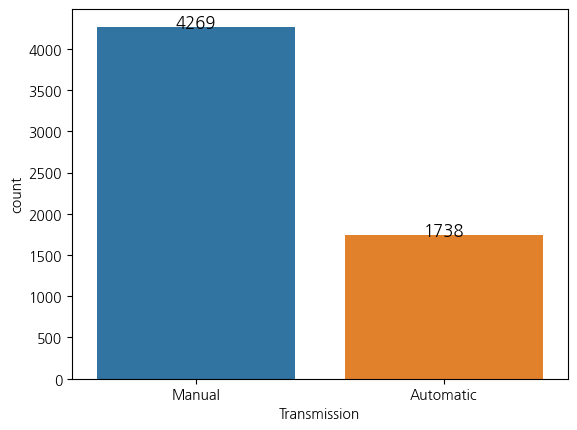

In [53]:
sns.countplot(df,x='Transmission')
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width() / 2, 
                   p.get_height() + 0.2, 
                   int(p.get_height()), 
                   ha='center', 
                   fontsize=12)
plt.show()

-> 수동 차량이 인도 시장에서 더 선호되고, 그 주요 이유가 가격 경쟁력과 도로 상황에 따른 실용성 때문임을 예상한다. 인도의 도로 상황이 좋지 않은 경우가 많아 운전자가 더 직접적으로 차량을 제어할 수 있는 수동 차량이 더 적합하게 느껴질 수 있다. 또한, 수동 차량이 상대적으로 저렴하기 때문에 가성비 차량을 선호하는 인도 소비자들에게 더 매력적으로 다가올 수 있다고 예상한다.

### 3) 연료 선호도
- petrol과 diesel 연비 비교
- 일반적으로 Diesel 연료가 연비가 더 좋다.
- 차량 사용이 많거나 주행거리가 많다면 Diesel 차량이 적합하다.
- 그렇다면 인도는 땅이 크니까 Diesel이 선호되지 않을까?

In [54]:
df_filtered = df[df['Fuel_Type'].isin(['Petrol', 'Diesel'])]
df_filtered.groupby('Fuel_Type')['Mileage'].mean()

Fuel_Type
Diesel    18.825218
Petrol    17.783592
Name: Mileage, dtype: float64

<Axes: xlabel='Fuel_Type', ylabel='Mileage'>

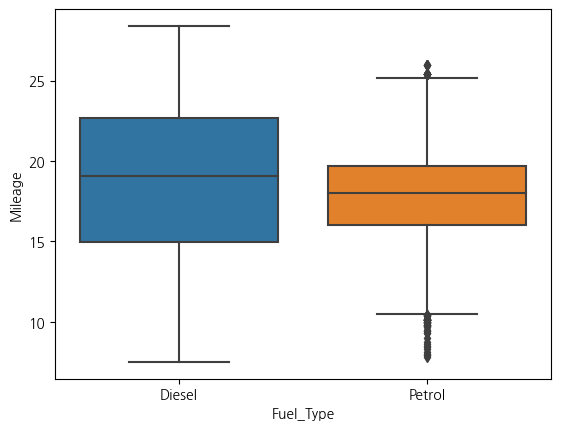

In [55]:
sns.boxplot(df_filtered,x='Fuel_Type',y='Mileage')

- 평균으로 비교했을 때, 디젤이 연비가 더 뛰어나다고 할 수 있지만, 데이터 분포 상으로는 확인이 어렵다.
- 그렇다면 어떤 연료가 더 저렴할까?

In [57]:
# 인도 Patrol 평균 가격(8/11 기준)
# 출처 : www.financialexpress.com
# 데이터에 포함되는 지역 연료 가격 확인
# Patrol 평균 가격
price_p = (103.44+94.50+100.75+101.32+102.86+107.58+104.88+104.95+103.44+94.72)/10

# 원 단위 환산(8/11 기준)
price_p = price_p * 16.27
price_p

1657.00188

In [58]:
# 인도 Diesel 평균 가격(8/11 기준)
price_d = (90.17+88.94+92.34+92.92+95.81+90.36+91.76+89.97+87.62+90.61)/10
price_d = price_d * 16.27
price_d

1481.3835000000001

- 2024년 8월 11일의 인도 Petrol, Diesel 가격과 인도루피와 원화 환율을 기준으로 하였다.
- 디젤 연료가 저렴하다.
- 효율도 뛰어날까? (1원의 비용으로 얼마나 많은 거리를 주행할 수 있을까?) 

In [59]:
# 연료 효율 계산 함수
def calculate_fuel_efficiency(row):
    if row['Fuel_Type'] == 'Petrol':
        return row['Mileage'] / price_p
    elif row['Fuel_Type'] == 'Diesel':
        return row['Mileage'] / price_d
    else:
        return None

# 연료 효율 컬럼 생성
df['Fuel_efficiency'] = df.apply(calculate_fuel_efficiency, axis=1)

In [60]:
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Price_log,Power_log,Fuel_efficiency
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,5.0,Maruti,7.894572,4.063198,NaN
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,5.0,Hyundai,9.860684,4.837868,0.013278
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,5.0,Honda,8.839033,4.485260,0.010984
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,7.0,Maruti,9.126715,4.485936,0.014021
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,5.0,Audi,10.210778,4.947340,0.010261


In [61]:
df['Fuel_efficiency'] = df['Fuel_efficiency'] * 100

In [62]:
df_filtered = df[df['Fuel_Type'].isin(['Petrol', 'Diesel'])]

<Axes: xlabel='Fuel_Type', ylabel='Fuel_efficiency'>

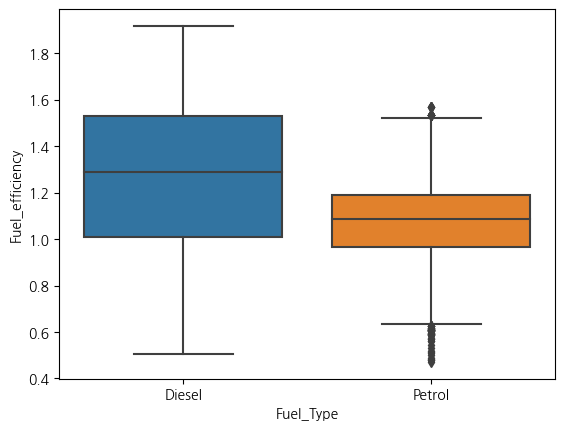

In [63]:
sns.boxplot(df_filtered,x='Fuel_Type',y='Fuel_efficiency')

- 디젤 차량이 연료 효율이 뛰어난 것으로 확인된다.
- 선호도는 어떻게 될까?

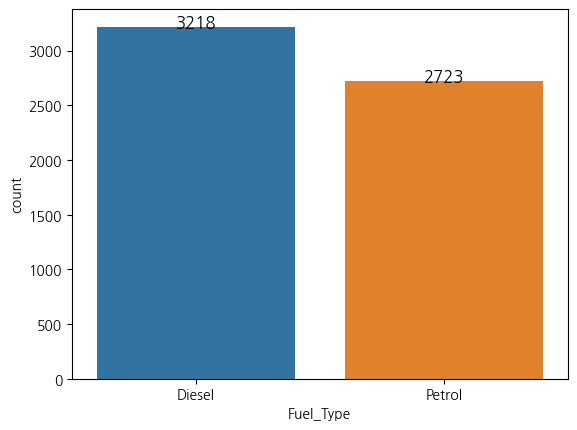

In [64]:
sns.countplot(df_filtered,x='Fuel_Type')
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width() / 2, 
                   p.get_height() + 0.2, 
                   int(p.get_height()), 
                   ha='center', 
                   fontsize=12)
plt.show()

- Patrol/Diesel 차량 거래내역 5947건 중 54.2%의 비율로 Diesel 차량이 거래되었다.
- Deisel 차량이 좀 더 선호되는 경향을 보인다고 판단하였다.
- 큰 차이로 볼 수 없지만 인도 중고차 시장에서 연료가 저렴하고 효율이 좋은 Diesel 차량이 경쟁력이 있을 것으로 판단하였다.

### 4) 저렴한 브랜드가 선호된다.

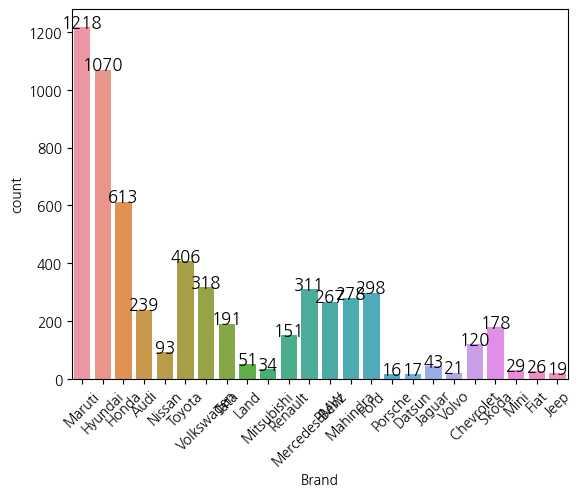

In [65]:
sns.countplot(df,x='Brand')
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width() / 2, 
                   p.get_height() + 0.2, 
                   int(p.get_height()), 
                   ha='center', 
                   fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [66]:
n = df['Brand'].value_counts()
num_brand = pd.DataFrame(n)
num_brand.reset_index(inplace=True)
num_brand.sort_values(by='Brand',ascending=False)

,index,Brand
0,Maruti,1218
1,Hyundai,1070
2,Honda,613
3,Toyota,406
4,Volkswagen,318
5,Mercedes-Benz,311
6,Ford,298
7,Mahindra,278
8,BMW,267
9,Audi,239


- Maruti(인도), Hyundai(한국), Honda(일본), Toyota(일본) -> 아시아 차량이 선호된다(전체 55.0%)
- 해당 브랜드의 형성된 가격대 확인 

In [67]:
df_filtered_brand = df_filtered = df[df['Brand'].isin(['Maruti', 'Hyundai','Honda','Toyota'])]
df_filtered_brand

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Price_log,Power_log,Fuel_efficiency
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,5.0,Maruti,7.894572,4.063198,NaN
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,5.0,Hyundai,9.860684,4.837868,1.327813
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,5.0,Honda,8.839033,4.485260,1.098369
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,7.0,Maruti,9.126715,4.485936,1.402068
5,Hyderabad,2012,75000,LPG,Manual,First,21.10,814.0,5.0,Hyundai,8.189372,4.010963,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7218,Mumbai,2018,3800,Diesel,Automatic,First,24.30,1248.0,5.0,Maruti,9.857479,4.483003,1.640358
7220,Delhi,2017,14300,Diesel,Automatic,First,28.40,1248.0,5.0,Maruti,9.544329,4.300681,1.917127
7221,Coimbatore,2018,31542,Petrol,Manual,First,17.40,1497.0,5.0,Honda,9.874982,4.764735,1.050089
7235,Kochi,2017,21380,Diesel,Manual,First,24.30,1248.0,5.0,Maruti,9.692976,4.483003,1.640358


In [69]:
df_filtered_brand['Price_log'].describe()

count    3307.000000
mean        8.933466
std         0.650191
min         1.957274
25%         8.528879
50%         8.932321
75%         9.315957
max        11.039216
Name: Price_log, dtype: float64

- 거래량이 많은 4개 브랜드의 평균 가격은 8.933466천원(log 변환 기준, 변환 전 9320.354947천원)이다.
- 그 외 브랜드와 비교해보았다.

In [71]:
# 타 브랜드와 비교
df_filtered_brand_2 = df[~df['Brand'].isin(['Maruti', 'Hyundai', 'Honda', 'Toyota'])]
df_filtered_brand_2['Price_log'].describe()

count    2700.000000
mean        9.516216
std         0.991061
min         6.513972
25%         8.783637
50%         9.407498
75%        10.305370
max        12.410130
Name: Price_log, dtype: float64

- 그 외 브랜드의 평균 거래 가격은 9.516216천원이다.(log 변환 기준, 변환 전 21883.434786천원)
- 평균 가격으로 비교했을 때, 선호도가 높은 네 브랜드가 더 저렴하다고 볼 수 있다.

<Axes: xlabel='Brand', ylabel='Price_log'>

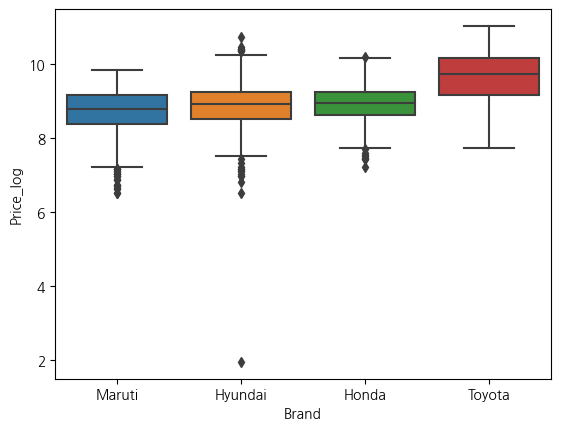

In [73]:
sns.boxplot(df_filtered_brand,x='Brand',y='Price_log')

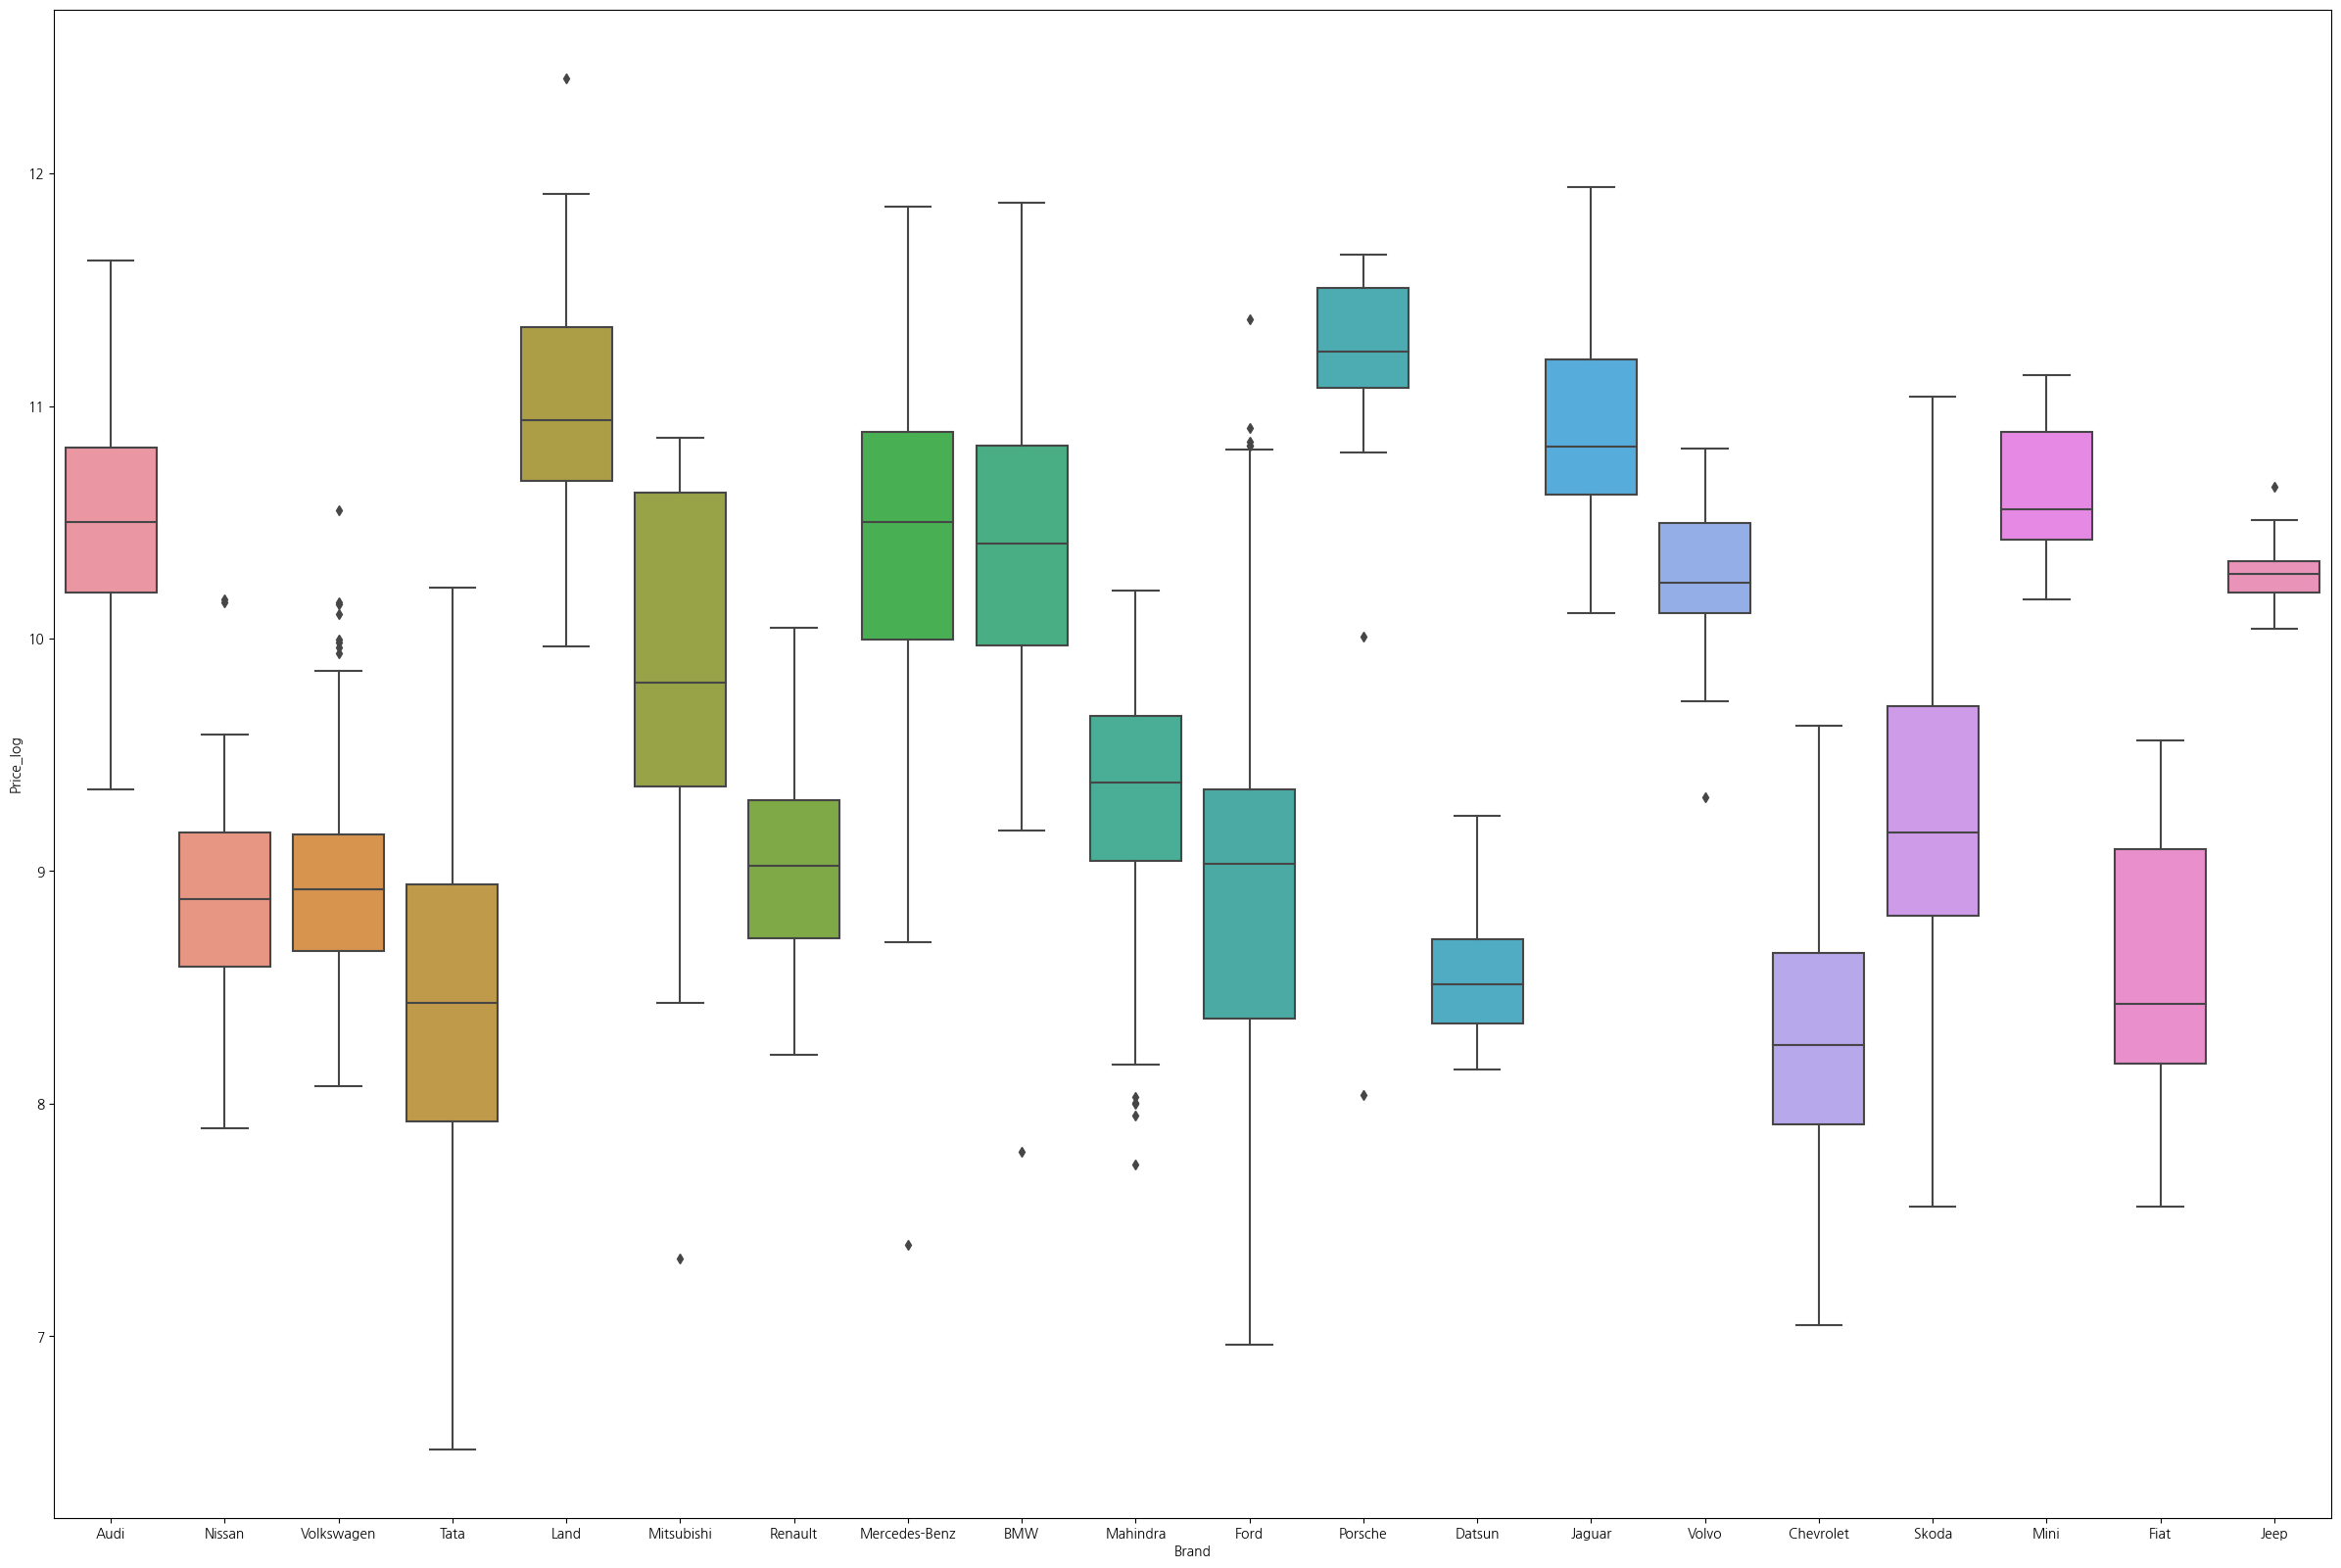

In [75]:
plt.figure(figsize=(30,20))
sns.boxplot(df_filtered_brand_2,x='Brand',y='Price_log')
plt.show()

- 아시아 브랜드들은 대체로 가격이 낮은 편이며, 이는 사람들이 상대적으로 저렴한 브랜드를 선호한다는 것을 시사할 수 있다.
- 나머지 브랜드들의 가격 분포는 상대적으로 높은 편이며, 일부 브랜드(Mercedes, Land Rover, Porsche 등)는 매우 높은 가격 범위를 가지고 있다. 

-> 따라서 고객들이 일반적으로 저렴한 브랜드를 선호한다는 결론을 도출할 수 있지만 특정 고급 브랜드들의 경우 가격이 높아도 특정 시장에서 선호될 수 있음을 고려해야 한다.

### 5) 수치형 변수 간 관계

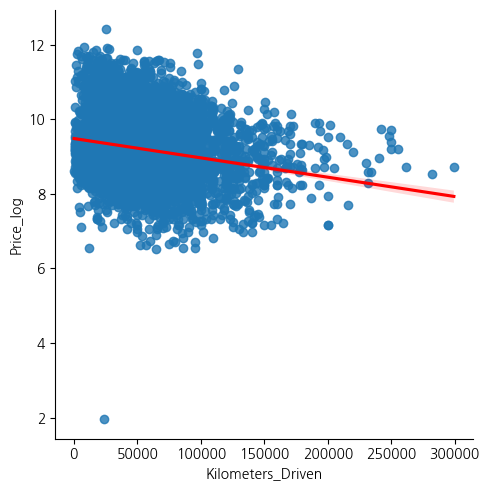

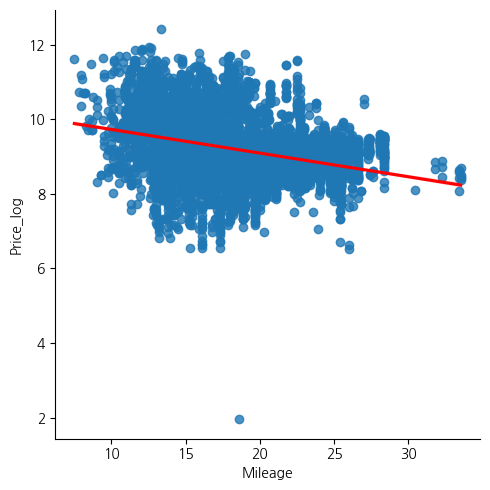

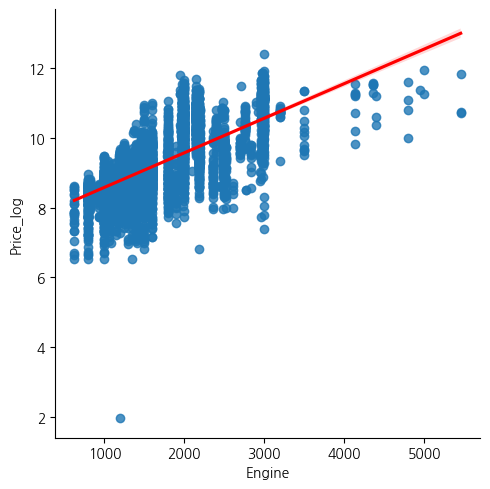

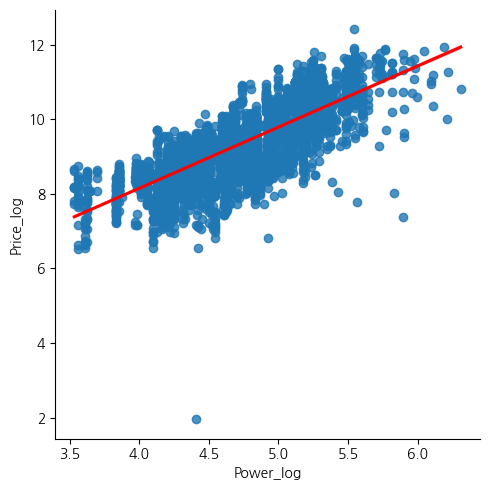

In [105]:
sns.lmplot(data=df, x='Kilometers_Driven', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Mileage', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Engine', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Power_log', y='Price_log',line_kws={'color':'red'})

fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

연속형 설명변수와 목표변수 Price_log 간 관계를 산점도를 통해 시각화하였다.

1. Kilometers_Driven과 Price간은 약한 음의 상관관계를 보였다. 이는 주행거리가 많을수록 가격은 낮아진다는 사실과 부합한다. 그러나 신뢰구간이 퍼져있는 경향과 산점도의 분포를 보았을 때 확신하기 어렵다.
2. Mileage와 Price간은 약한 음의 상관관계를 보였다. 이는 마일리지(연비)가 높을수록 차의 성능이 좋기 때문에 판매 금액이 높을 것이라는 가정과 불일치한다. 그러나 다른 변수의 영향도 고려해야 하고, 상관성이 약하기 때문에 그대로 가정을 유지하겠다.
3. 차량의 Engine(배기량)이 Price 간 양의 상관관계를 보였다. 이는 배기량이 커질수록, 차량의 사이즈가 커져 차량의 판매 금액이 증가하는 가정과 부합한다.
4. Power_log와 Price_log 또한 가장 큰 양의 상관관계를 보였다. 이는 출력이 높은 차량의 성능이 좋기 때문에 판매 금액이 높을 것이라는 가정과 부합한다.

#### 데이터 분포

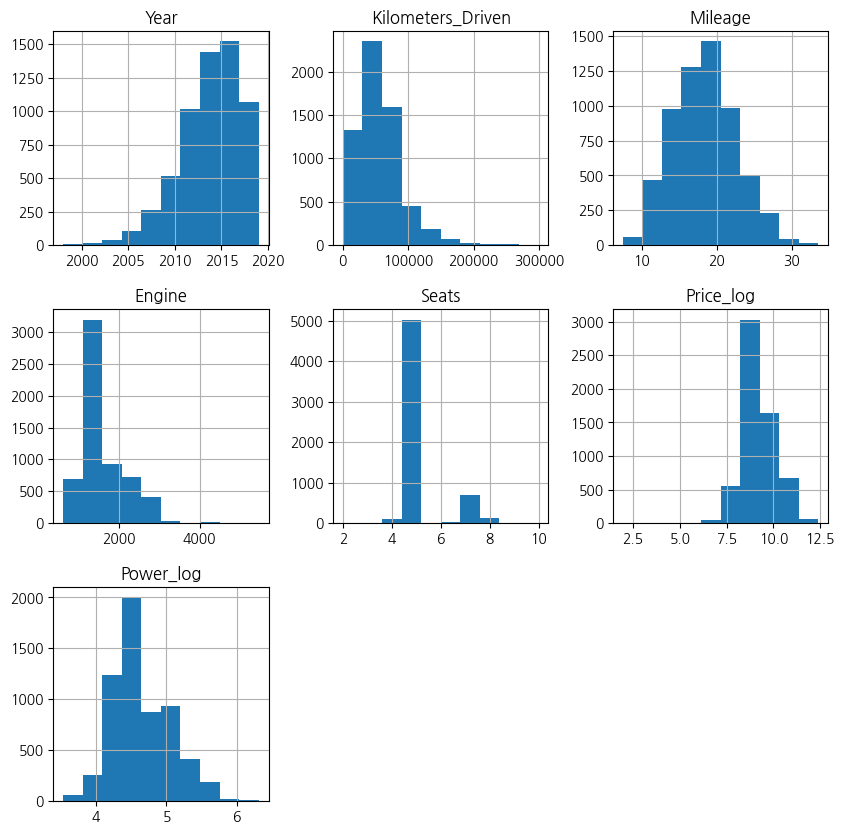

In [106]:
df.hist(figsize = (10, 10)) #히스토그램 - 데이터의 전반적인 분포를 파악
fig.subplots_adjust(wspace=0.4, hspace=0.8)

1. Year
    - 분포가 오른쪽으로 치우쳐 있으며, 대부분의 데이터가 비교적 최근 연식, 특히 2010년 이후에 집중되어 있다. 2015년경 데이터가 가장 많이 분포되어 있다.
2. Kilometers Driven (주행 거리)
    - 분포가 좌측으로 치우쳐 있으며, 대부분의 차량이 비교적 적은 주행 거리를 가진 것으로 보인다.
    - 분포가 긴 꼬리를 가지는 것으로 보아 이상치 혹은 주행거리가 큰 데이터가 포함되어 있는 것으로 보인다.
3. Mileage (연비)
    - 연비는 대체로 정규 분포에 가까운 모양을 보이며, 대부분의 차량이 중간 근처에 분포해있다.
4. Engine (엔진 배기량):
    - 엔진 배기량의 분포는 왼쪽으로 치우쳐 있으며, 대다수의 차량이 낮은 배기량에 분포되어 있다.
5. Seats (좌석 수):
    - 대부분의 차량이 4~5개의 좌석을 가지고 있으며, 좌석 수가 6개 이상인 차량은 매우 적습니다.
6. Price_log:
    - 기존 Price에 로그를 취해 대체로 정규 분포를 따른다.
7. Power_log (출력 로그 변환):
    - 출력 로그 변환 값도 대체로 정규 분포에 가까운 형태를 보인다.

#### 상관관계

<Axes: >

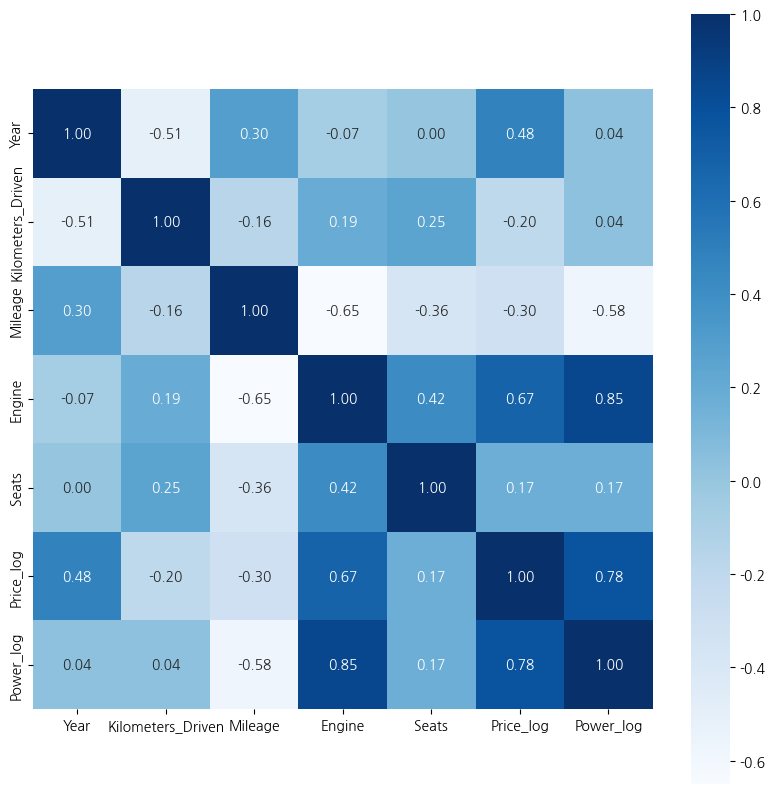

In [107]:
num = df.select_dtypes(include=np.number) 
plt.figure(figsize=(10, 10))
sns.heatmap(num.corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 10},cmap='Blues')

히트맵을 통해 수치형 변수간 상관관계를 시각화하였다.
- 설명변수와 목표변수 간 상관관계
    1. 앞서 산점도를 통해 차량의 Power_log(차량의 출력)이 Price_log(판매금액)에 영향을 끼치는 것을 추측할 수 있었다. 실제로 차량 출력과 판매금액은 높은 상관관계를 보이는 것을 확인할 수 있다.
    2. 차량의 Engine(배기량)이 증가하면 Price_log(판매금액)이 증가할 수 있다.

- 수치형 설명 변수 간 상관관계
    1. Engine과 Power_log는 0.85의 큰 양의 상관관계를 보인다.
    2. Engine과 Mileage는 -0.65로 음의 상관관계를 보인다.
    - 이러한 상관관계가 다중공선성으로 모델의 성능에 영향을 끼칠 수 있기 때문에 추후 다중공선성 검사를 통해 확인해야 한다.

### 6) 범주형 변수 간 관계

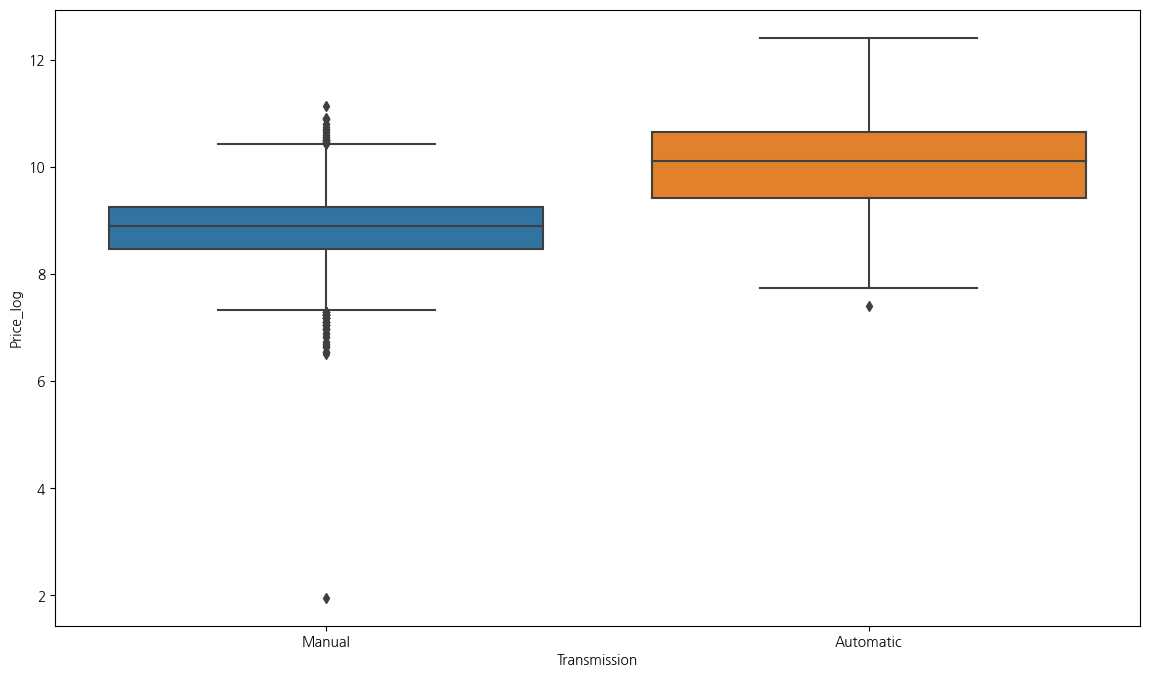

In [108]:
# Transmission과 Price_log boxplot
plt.figure(figsize=(14,8))
sns.boxplot(x='Transmission',y='Price_log',data=df)
plt.show()

차량의 Transmission에 따른 판매가격
- Automatic의 가격이 Manual에 비해 높게 형성되어있다.
- 앞서 인도의 도로 사정과 가격 문제로 manual 차량이 더 선호되는 것인 도메인 지식과 부합한다.

Text(0.5, 1.0, 'Price Distribution by Location')

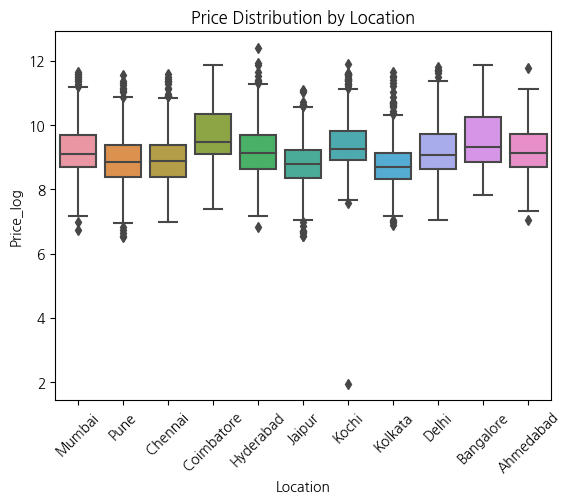

In [109]:
# Location 별 Price
sns.boxplot(x='Location', y='Price_log', data=df)
plt.xticks(rotation=45)  # X축 라벨을 45도 회전
plt.title('Price Distribution by Location')

- 지역 별 가격은 전반적으로 비슷한 분포를 형성하고 있다.
- 확신할 수는 없지만 Delhi, Mumbai, Chennai, Kolkata, Hyderabad 5개의 도시에서 특정하게 평균 가격이 높은 차량을 선호한다는 가정에 부합하지 않는다.

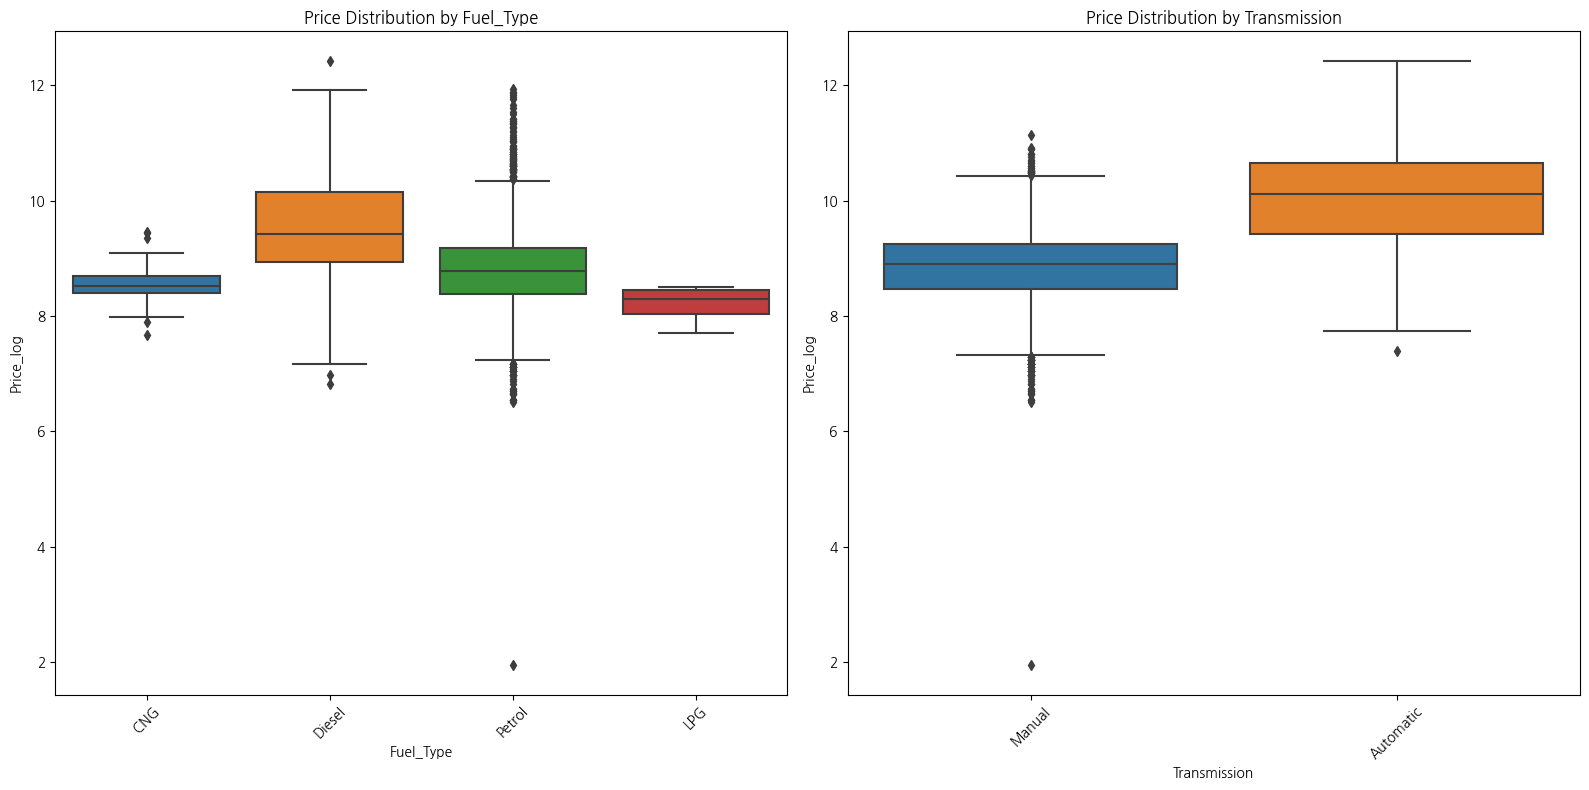

In [110]:
categorical_columns = ['Fuel_Type', 'Transmission']

# Subplots 생성
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(16, 8))

# 각 범주형 변수에 대해 Boxplot 생성
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Price_log', data=df, ax=axes[i])
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=45)  # X축 라벨 회전

plt.tight_layout()
plt.show()

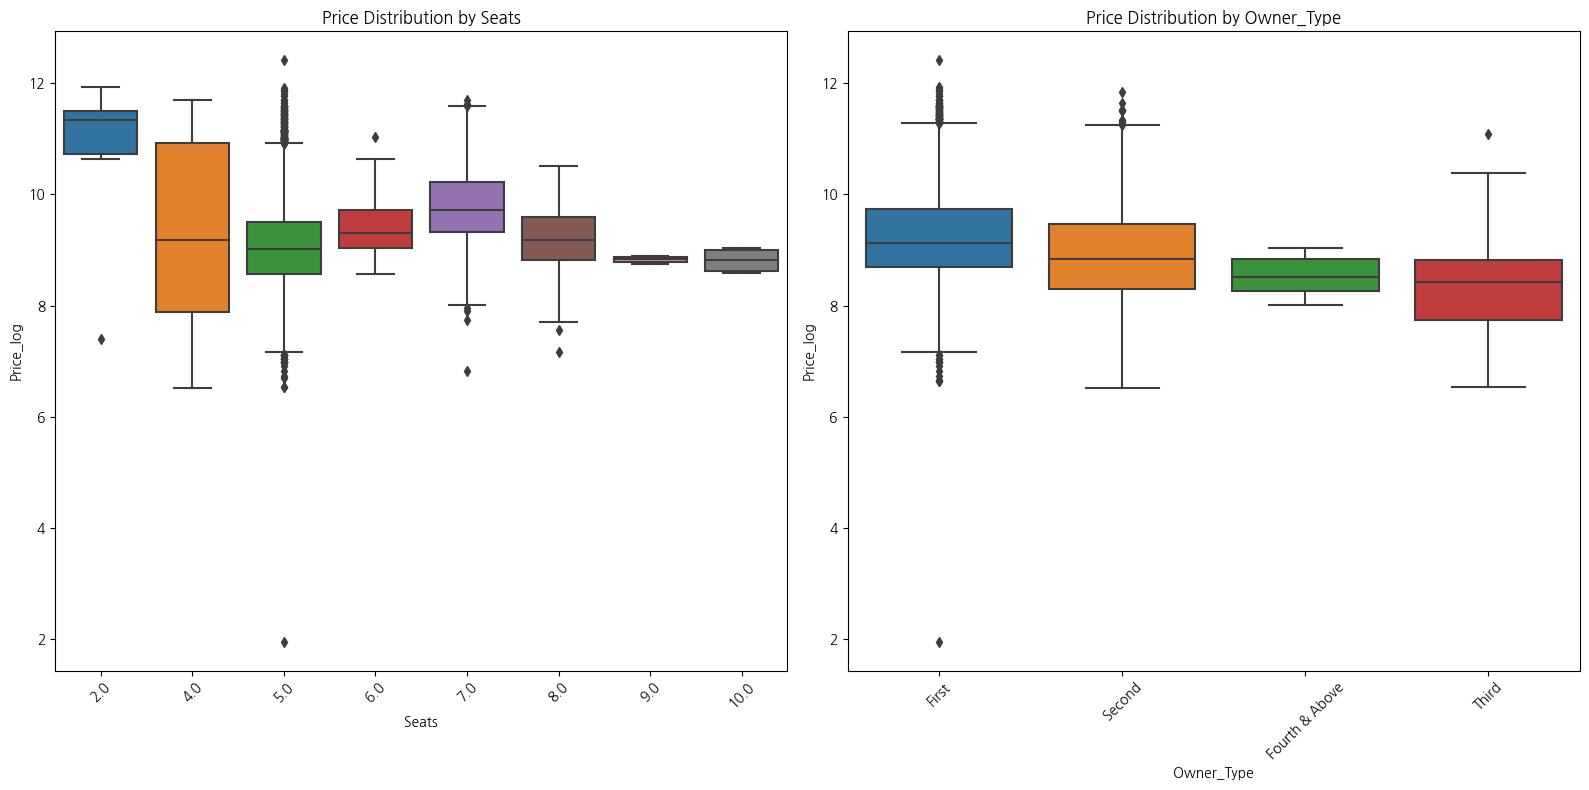

In [111]:
categorical_columns =['Seats','Owner_Type']
# Subplots 생성
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(16, 8))

# 각 범주형 변수에 대해 Boxplot 생성
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Price_log', data=df, ax=axes[i])
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=45)  # X축 라벨 회전

plt.tight_layout()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'Maruti'),
  Text(1, 0, 'Hyundai'),
  Text(2, 0, 'Honda'),
  Text(3, 0, 'Audi'),
  Text(4, 0, 'Nissan'),
  Text(5, 0, 'Toyota'),
  Text(6, 0, 'Volkswagen'),
  Text(7, 0, 'Tata'),
  Text(8, 0, 'Land'),
  Text(9, 0, 'Mitsubishi'),
  Text(10, 0, 'Renault'),
  Text(11, 0, 'Mercedes-Benz'),
  Text(12, 0, 'BMW'),
  Text(13, 0, 'Mahindra'),
  Text(14, 0, 'Ford'),
  Text(15, 0, 'Porsche'),
  Text(16, 0, 'Datsun'),
  Text(17, 0, 'Jaguar'),
  Text(18, 0, 'Volvo'),
  Text(19, 0, 'Chevrolet'),
  Text(20, 0, 'Skoda'),
  Text(21, 0, 'Mini'),
  Text(22, 0, 'Fiat'),
  Text(23, 0, 'Jeep')])

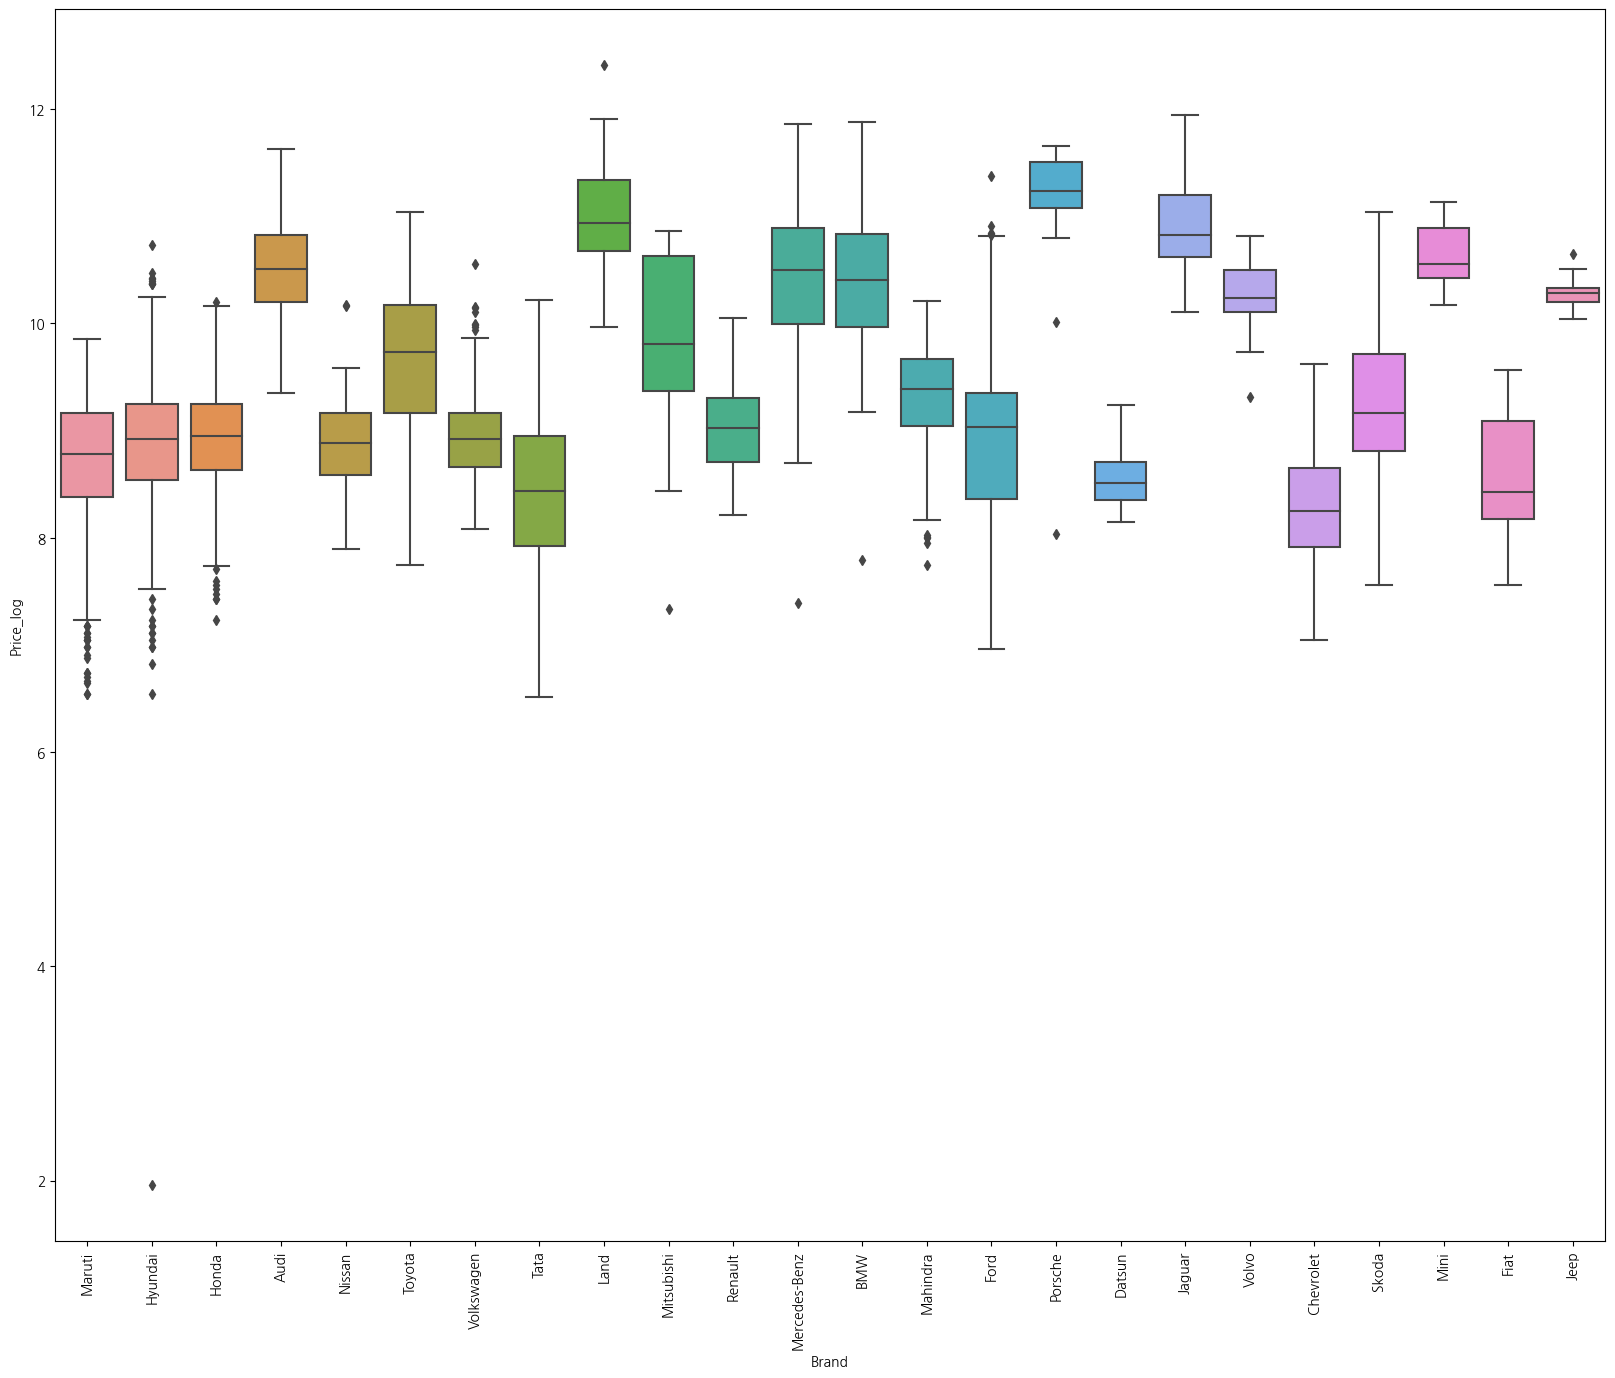

In [112]:
plt.figure(figsize=(20,16))
sns.boxplot(x='Brand',y='Price_log',data=df)
plt.xticks(rotation=90)

In [113]:
p = df['Price_log'].min()
df[df['Price_log'] == p]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Price_log,Power_log
7236,Kochi,2018,23955,Petrol,Manual,First,18.6,1197.0,5.0,Hyundai,1.957274,4.40501


In [114]:
# 이상치라 판단하여 제거
df=df[df['Price_log'] != p]
df['Price_log'].min()

6.51397167564781

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Mumbai'),
  Text(1, 0, 'Pune'),
  Text(2, 0, 'Chennai'),
  Text(3, 0, 'Coimbatore'),
  Text(4, 0, 'Hyderabad'),
  Text(5, 0, 'Jaipur'),
  Text(6, 0, 'Kochi'),
  Text(7, 0, 'Kolkata'),
  Text(8, 0, 'Delhi'),
  Text(9, 0, 'Bangalore'),
  Text(10, 0, 'Ahmedabad')])

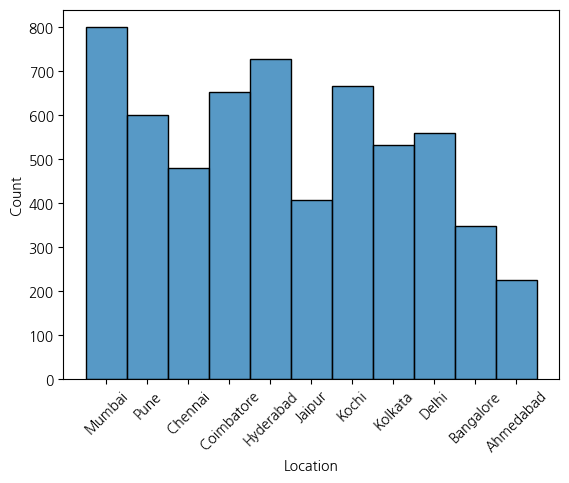

In [115]:

sns.histplot(df['Location'])
plt.xticks(rotation=45)

- 도시 상 가격의 큰 차이는 보이지 않는다.

종합적으로 분석해보았을 때, 2가지 상관관계를 고려해볼 수 있다.
1) Engine(배기량)과 가격은 양의 상관 관계를 보인다.
2) Power(최대출력)과 가격은 양의 상관 관계를 보인다.

### 데이터 분리

In [50]:
df_train, df_test = train_test_split(df,test_size=0.3)

### 7) Logistic Regression

In [51]:
reg_model = smf.ols(formula = "Price_log ~ Year + Kilometers_Driven + Mileage + Engine + Power_log ", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_log   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     4193.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:04:20   Log-Likelihood:                -1545.0
No. Observations:                4209   AIC:                             3102.
Df Residuals:                    4203   BIC:                             3140.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -250.3866      4.17

In [52]:
cols = df_train.select_dtypes(['int','float']).columns
df_train_const = add_constant(df_train[cols])
df_vif = pd.DataFrame()
df_vif['variable'] = df_train_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_const.values, i) for i in range(df_train_const.shape[1])]
df_vif.sort_values('VIF', ascending = True).round(2)

# VIF 검사 상 이상 X

,variable,VIF
2,Kilometers_Driven,1.41
5,Seats,1.58
3,Mileage,2.08
1,Year,2.86
4,Engine,5.97
6,Price_log,5.99
7,Power_log,6.84
0,const,1161922.99


로그 변환된 가격(Price_log)을 종속 변수로 사용하고, 연도(Year), 주행 거리(Kilometers_Driven), 연비(Mileage), 엔진 크기(Engine), 그리고 로그 변환된 출력(Power_log)을 독립 변수로 사용한 OLS(최소자승법) 회귀 모델

1. R-squared: 0.842 / Adj. R-squared: 0.842
-> 높은 설명력을 가진다.

2. F-statistic: 4485 / Prob (F-statistic): 0.00
p-value가 0.05보다 작으므로 이 모델이 통계적으로 매우 유의미하다는 것을 의미한다.

3. Coefficients (회귀 계수)
- Year (연도): 0.1222
연도가 1년 증가할 때마다 Price_log는 약 0.1222만큼 증가합니다. 이는 연식이 높은 차일수록 가격이 높아질 가능성이 있음을 의미한다.
- Kilometers_Driven (주행 거리): -7.28e-07
주행 거리가 1km 증가할 때 Price_log는 약 7.28e-07만큼 감소합니다. 이는 주행 거리가 많을수록 가격이 약간 낮아질 가능성이 있음을 의미한다.
- Mileage (연비): 0.0133
연비가 1 단위 증가할 때 Price_log는 약 0.0133만큼 증가한다. 연비가 좋을수록 차량 가격이 높아질 가능성이 있음을 나타낸다.
- Engine (엔진 크기): 0.0004
엔진 크기가 1 단위 증가할 때 Price_log는 0.0004만큼 증가한다. 엔진 크기가 클수록 차량 가격이 높을 가능성이 있음을 나타낸다.
- Power_log (로그 변환된 출력): 1.2172
출력이 1 단위 증가할 때 Price_log는 약 1.2172만큼 증가한다. 출력이 클수록 차량 가격이 크게 증가할 가능성이 있음을 나타낸다.

4. t-Statistic과 P>|t| (t-통계량과 p-값)
각 변수의 t-통계량과 p-값을 보면, 모든 변수들이 통계적으로 유의미하다. (p-값이 모두 0.05 이하).

5. 다중공선성 (VIF >= 10)
대부분의 변수들의 VIF 값이 10 미만으로 다중공선성은 심각하지 않다.

### 8) 연속형 변수 vs 연속형 변수 : 상관분석

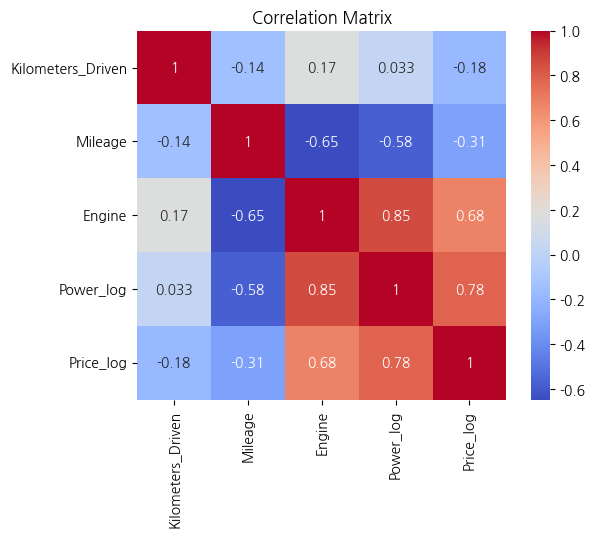

Correlation with Price_log:
Kilometers_Driven   -0.182260
Mileage             -0.306506
Engine               0.676819
Power_log            0.783110
Price_log            1.000000
Name: Price_log, dtype: float64


In [53]:
# 상관 분석
variables = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power_log']

# 변수들 간의 상관 계수 행렬 계산
corr_matrix = df[variables + ['Price_log']].corr()

# Heatmap으로 상관 계수 행렬 시각화
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Price_log과 각 변수들 간의 상관 계수
print('Correlation with Price_log:')
print(corr_matrix['Price_log'])

변수 간 상관관계 클수록 색이 진하고, 상관계수가 양수이면 빨간색, 음수이면 파란색 계열로 표현한다.

1. Price_Log와 Power_Log 상관계수 : 0.78
-> Power_log와 Price_log는 강한 양의 상관관계를 가지고 있다. 차량의 엔진 출력(Power_log)이 높을수록 가격(Price_log)도 높은 경향이 있음을 의미한다.

2. Price_Log와 Engine 상관계수 : 0.68
-> Engine과 Price_log는 강한 양의 상관관계를 가지고 있다.. 이는 엔진의 크기나 배기량(Engine)이 클수록 가격이 높아질 경향이 있음을 의미한다.

3. Engine과 Power_Log 상관계수 : 0.85
-> Engine과 Power_log는 매우 강한 양의 상관관계를 가지고 있다. 이는 엔진 크기나 배기량이 클수록 출력(Power_log)도 높다는 것을 의미한다.

4. Mileage와 Engine 상관계수 : -0.65
-> Power_log와 Price_log는 강한 양의 상관관계를 가지고 있다. 일반적으로 엔진이 클수록 연비(Mileage)가 낮아지는 경향이 있음을 나타낸다.

5. Mileage와 Power_Log 상관계수 : -0.58
-> Mileage와 Power_log도 강한 음의 상관관계를 보인다. 주행 거리가 많을수록 차량 가격이 약간 낮아질 수 있음을 나타내지만, 매우 강한 상관관계는 아니다.

6. Kilometers_Driven과 Price_Log 상관계수 :  -0.18
-> Kilometers_Driven과 Price_log는 약한 음의 상관관계를 가지고 있다.  차량의 엔진 출력(Power_log)이 높을수록 가격(Price_log)도 높은 경향이 있음을 의미한다.

7. Kilometers_Driven과 다른 변수들 
-> 다른 변수들과의 상관계수는 대부분 매우 낮거나, 거의 상관관계가 없다. 이는 주행 거리(Kilometers_Driven)가 이들 변수들과 큰 관련이 없다는 것을 의미한다.

종합적으로 이 상관행렬은 차량의 출력과 엔진 크기가 가격에 큰 영향을 미치며, 연비는 이들 변수와 반비례 관계가 있음을 나타낸다.


### 9) 범주형 vs 범주형 비교 : 카이제곱 검정

In [54]:
from scipy.stats import chi2_contingency

# 범주형 변수 선택
categorical_variables = ['Fuel_Type', 'Transmission', 'Seats', 'Owner_Type', 'Brand']

# 각 변수와 Price_log 간의 독립성을 평가하는 카이제곱 검정 수행
for var in categorical_variables:
    contingency_table = pd.crosstab(df[var], df['Price_log'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f'Chi-square test for {var}:')
    print('Chi-square statistic:', chi2)
    print('p-value:', p_value)
    print()

Chi-square test for Fuel_Type:
Chi-square statistic: 4015.9530385865764
p-value: 0.9995354977421873

Chi-square test for Transmission:
Chi-square statistic: 3577.8140047378765
p-value: 1.4629572788212097e-182

Chi-square test for Seats:
Chi-square statistic: 12781.13890062242
p-value: 1.207893964339198e-69

Chi-square test for Owner_Type:
Chi-square statistic: 2847.3505028706527
p-value: 1.0

Chi-square test for Brand:
Chi-square statistic: 48778.6825628094
p-value: 0.0



1. Fuel_Type: p-value가 0.9995로 매우 커서 다른 변수들과 유의미한 관계가 없고, 독립적이다.

2. Transmission, Seats, Brand: p-value가 매우 작아 유의미한 관계가 있고, 독립적이지 않다.

3. Owner_Type: p-value가 1.0으로, 다른 변수들과 유의미한 관계가 없고, 독립적이다.

즉, Transmission, Seats, Brand는 중요한 변수로 고려해야 하고, Fuel_Type과 Owner_Type은 독립적이어서 상대적으로 영향이 적다.

### 10) 범주형 vs 연속형 : ANOVA

In [55]:
# 범주형 변수 선택
categorical_variables = ['Fuel_Type', 'Transmission', 'Seats', 'Owner_Type', 'Brand']

# 각 범주형 변수와 Price_log 간의 ANOVA 검정 수행
for var in categorical_variables:
    formula = f'Price_log ~ C({var})'  # ANOVA 모델 formula 생성
    model = ols(formula, data=df).fit()  # ANOVA 모델 피팅
    anova_table = sm.stats.anova_lm(model)  # ANOVA 결과 테이블 생성
    
    print(f'ANOVA test for {var}:')
    print(anova_table)
    print()

ANOVA test for Fuel_Type:
                  df       sum_sq     mean_sq           F         PR(>F)
C(Fuel_Type)     3.0   829.018841  276.339614  451.612699  1.320279e-264
Residual      6009.0  3676.877871    0.611895         NaN            NaN

ANOVA test for Transmission:
                     df       sum_sq      mean_sq            F  PR(>F)
C(Transmission)     1.0  1680.343566  1680.343566  3574.714276     0.0
Residual         6011.0  2825.553147     0.470064          NaN     NaN

ANOVA test for Seats:
              df       sum_sq    mean_sq          F        PR(>F)
C(Seats)     7.0   331.266632  47.323805  68.072965  5.897999e-95
Residual  6005.0  4174.630080   0.695192        NaN           NaN

ANOVA test for Owner_Type:
                   df       sum_sq    mean_sq          F        PR(>F)
C(Owner_Type)     3.0   166.955408  55.651803  77.072184  6.479045e-49
Residual       6009.0  4338.941305   0.722074        NaN           NaN

ANOVA test for Brand:
              df       sum_

1. Fuel_Type: F-통계량: 451.61 / p-value: 1.320279e-264
-> 연료 유형(Fuel_Type)에 따라 그룹 간 평균 차이가 통계적으로 유의미하다. 즉, 연료 유형이 결과 변수에 영향을 미친다고 할 수 있다.

2. Transmission: F-통계량: 3574.71 / p-value: 0.0
-> 변속기 유형(Transmission)에 따른 그룹 간 평균 차이가 통계적으로 유의미하다. 즉, 변속기 유형도 결과 변수에 영향을 미친다고 할 수 있다.

3. Seats: F-통계량: 68.07 / p-value: 5.897999e-95
-> 좌석 수(Seats)에 따른 그룹 간 평균 차이도 통계적으로 유의미하다. 즉, 좌석 수가 결과 변수에 영향을 미친다고 할 수 있다.

4. Owner_Type: F-통계량: 77.07 / p-value: 6.479045e-49
-> 소유자 유형(Owner_Type)에 따른 그룹 간 평균 차이도 통계적으로 유의미하다. 즉, 소유자 유형이 결과 변수에 영향을 미친다고 할 수 있다.

5. Brand: F-통계량: 326.32 / p-value: 0.0
-> 브랜드(Brand)에 따른 그룹 간 평균 차이도 통계적으로 유의미하다. 즉, 브랜드가 결과 변수에 영향을 미친다고 할 수 있다.

모든 변수(Fuel_Type, Transmission, Seats, Owner_Type, Brand)에서 매우 낮은 p-value가 나타났으며, 이는 각 변수별로 그룹 간 평균 차이가 통계적으로 유의미함을 의미한다. 즉, 이 변수들은 모두 결과 변수에 중요한 영향을 미친다고 해석할 수 있다.

# 4. 모델링

### 범주형 변수 라벨링
- 범주형 변수들의 모델링을 위해 라벨링을 진행하였다.

In [43]:
df['Location'].unique()

array(['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad'],
      dtype=object)

In [44]:
loc = df['Location'].values
list1=['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad']

In [46]:
#Owner_Type값을 수치형으로 변환
#re_Owner_Type = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4}
#df['Owner_Type'] = df['Owner_Type'].map(re_Owner_Type)

# Fuel_Type의 데이터 값을 0, 1, 2, 3, 4로 변경
# Diesel -> 0, Petrol -> 1, CNG -> 2, 'LPG' -> 3, 'Electric' -> 4
df['Fuel_Type'] = df['Fuel_Type'].replace('Diesel', 0)
df['Fuel_Type'] = df['Fuel_Type'].replace('Petrol', 1)
df['Fuel_Type'] = df['Fuel_Type'].replace('CNG', 2)
df['Fuel_Type'] = df['Fuel_Type'].replace('LPG', 3)
df['Fuel_Type'] = df['Fuel_Type'].replace('Electric', 4)

# Transmission의 데이터 값을 1, 2로 변경
# Manual -> 1, Automatic -> 2
df['Transmission'] = df['Transmission'].replace('Manual', 1)
df['Transmission'] = df['Transmission'].replace('Automatic', 2)

#df['Location']=df['Location'].replace({"Mumbai":0,})

for i,l in enumerate(list1):
    df['Location'] = df['Location'].replace({l: i})

df['Fuel_Type'] = df['Fuel_Type'].astype('int64') # 타입 변환
df['Transmission'] = df['Transmission'].astype('int64')


In [47]:
from sklearn.preprocessing import LabelEncoder #Brand 데이터 값 수치형으로 변환

le = LabelEncoder()
df['Brand'] = le.fit_transform(df['Brand'])

brand_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(brand_mapping)

{'Audi': 0, 'BMW': 1, 'Chevrolet': 2, 'Datsun': 3, 'Fiat': 4, 'Ford': 5, 'Honda': 6, 'Hyundai': 7, 'Jaguar': 8, 'Jeep': 9, 'Land': 10, 'Mahindra': 11, 'Maruti': 12, 'Mercedes-Benz': 13, 'Mini': 14, 'Mitsubishi': 15, 'Nissan': 16, 'Porsche': 17, 'Renault': 18, 'Skoda': 19, 'Tata': 20, 'Toyota': 21, 'Volkswagen': 22, 'Volvo': 23}


In [48]:
le = LabelEncoder()
df['Owner_Type'] = le.fit_transform(df['Owner_Type'])


In [49]:
df['Location'].value_counts()

0     800
4     729
6     668
3     653
1     600
8     560
7     532
2     481
5     409
9     348
10    227
Name: Location, dtype: int64

In [50]:
df_raw_y = df['Price_log']
df_raw_x = df.drop(['Price_log'], axis = 1, inplace = False)

In [51]:
# 데이터 분할(train, test 데이터 7:3 비율로 분할)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))    

train data X size : (4204, 11)
train data Y size : (4204,)
test data X size : (1803, 11)
test data Y size : (1803,)


### DecisionTree

In [65]:
# 기본 옵션으로 모델 생성
tree_uncustomized = DecisionTreeRegressor()
tree_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.851


In [66]:
# 최적 파라미터 튜닝 : min_samples_leaf
# train 및 test 설명력 결과 저장
train_score = []; test_score = [ ]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf = [n_leaf for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.849
1,2,0.979,0.867
2,3,0.964,0.878
3,4,0.954,0.887
4,5,0.945,0.889
5,6,0.938,0.889
6,7,0.933,0.887
7,8,0.928,0.886
8,9,0.924,0.887
9,10,0.920,0.884


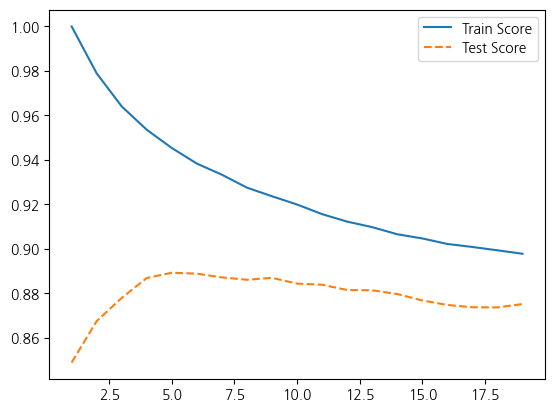

In [67]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.legend()
# min_samples_leaf 7 선택

In [68]:
# min_samples_split 설정
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분리 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor( min_samples_leaf=7
                                 , min_samples_split=v_min_samples_split )
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.933,0.887
1,6,0.933,0.887
2,8,0.933,0.887
3,10,0.933,0.887
4,12,0.933,0.887
5,14,0.933,0.887
6,16,0.930,0.885
7,18,0.929,0.886
8,20,0.927,0.885
9,22,0.924,0.886


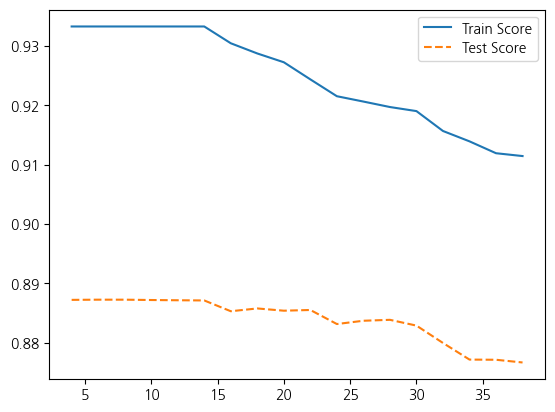

In [69]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.legend()
# min_samples_split 14 선택

In [70]:
# max_depth 설정
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(min_samples_leaf=7, min_samples_split=14
                                  , max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.484,0.438
1,2,0.640,0.614
2,3,0.748,0.733
3,4,0.804,0.788
4,5,0.848,0.831
5,6,0.876,0.858
6,7,0.896,0.868
7,8,0.909,0.875
8,9,0.919,0.880
9,10,0.926,0.884


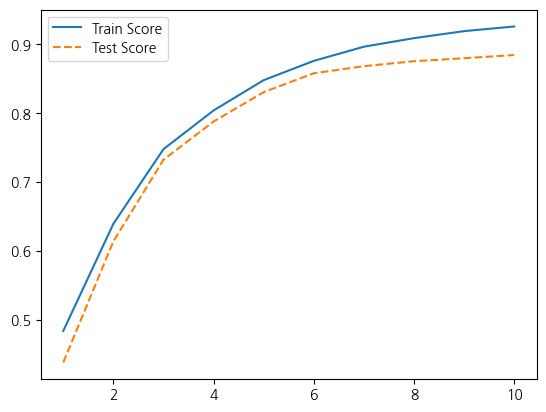

In [71]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.legend()
# max_depth 8 선택

In [73]:
# 최종 모델
dt_final = DecisionTreeRegressor( min_samples_leaf = 7,
                                 min_samples_split = 14, max_depth = 8)
dt_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(dt_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(dt_final.score(df_test_x, df_test_y)))

Score on training set: 0.909
Score on test set: 0.875


In [106]:
# GridSearchCV를 이용한 최적 parameter 찾기 
from sklearn.model_selection import GridSearchCV
para_depth = [depth for depth in range(1,11)]
para_split = [n_split*2 for n_split in range(2,20)]
para_leaf = [n_leaf * 2 for n_leaf in range(1,20)]

estimator = DecisionTreeRegressor()

param_grid = {"criterion": ["squared_error","friedman_mse","absolute_error"], "max_features" : [1.0],
                 "max_depth" : para_depth, "min_samples_split" : para_split, "min_samples_leaf" : para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model : \n{}".format(grid_dt.best_estimator_))
print("\n best parameter : \n {}".format(grid_dt.best_params_))
print("\n best score : \n {}".format(grid_dt.best_score_.round(3)))


best estimator model : 
DecisionTreeRegressor(max_depth=10, max_features=1.0, min_samples_leaf=6,
                      min_samples_split=14)

 best parameter : 
 {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 6, 'min_samples_split': 14}

 best score : 
 0.868


- DT의 최적 파라미터 : 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 6, 'min_samples_split': 14
- 설명력 : 0.868

In [74]:
# DT 최종 모델 선정
tree_final = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 6, min_samples_split = 14)
tree_final.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(tree_final.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.928
Score on test set: 0.883


In [75]:
# 설명변수 중요도 확인 및 테이블로 저장

v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
11,Power_log,0.691
1,Year,0.236
7,Engine,0.018
9,Brand,0.013
6,Mileage,0.012
0,Location,0.008
10,Size,0.008
2,Kilometers_Driven,0.006
3,Fuel_Type,0.005
4,Transmission,0.003


Text(0, 0.5, '변수')

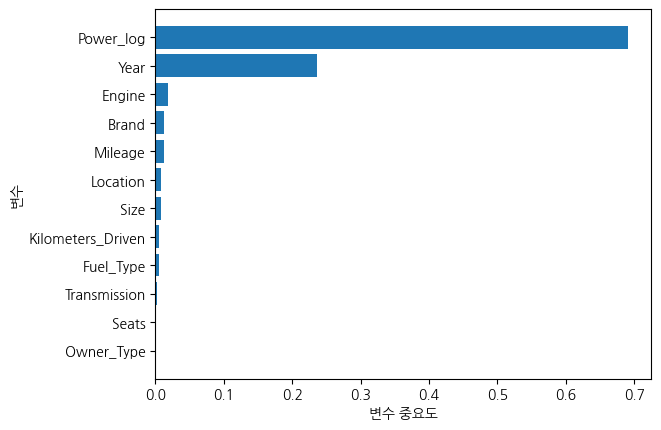

In [76]:
# 설명변수 중요도 그래프
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- GridSearch를 통해 구한 최적의 파라미터 값을 max_depth = 8, min_samples_leaf = 7, min_samples_split = 14로 설정하였다.
- 최적의 파라미터 값으로 구성한 최종 모델의 성능은 train 0.928 / test 0.886의 설명력을 보였다. 과적합으로 판단되지 않는다.
- 주요 인자를 추출한 결과, Power(최대 출력)이 Price에 가장 큰 영향을 끼치는 것으로 판단된다.
- 또한 Year 또한 Price에 영향을 미치는 2번째 주요 인자로 판단된다.


### Randomforest

In [77]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.987
Score on test set: 0.925


In [78]:
# 최적 파라미터 튜닝 : n_estimators
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# n_estimatos: 트리 수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.982,0.919
1,20,0.986,0.922
2,30,0.987,0.925
3,40,0.986,0.924
4,50,0.986,0.923
5,60,0.988,0.926
6,70,0.987,0.925
7,80,0.987,0.924
8,90,0.987,0.925
9,100,0.987,0.924


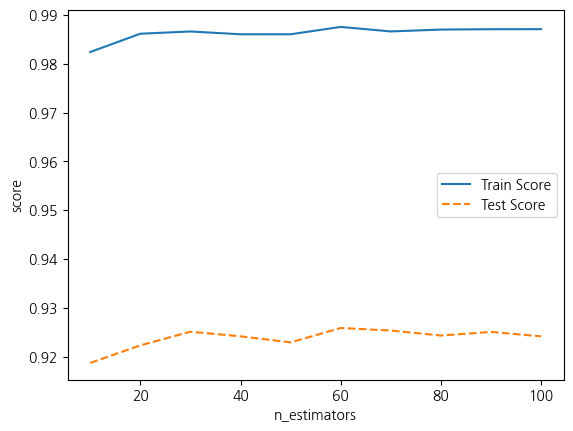

In [79]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()
# 80 선택

In [80]:
# min_samples_leaf
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수 
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor( n_estimators = 80,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.987,0.926
1,2,0.975,0.925
2,3,0.964,0.922
3,4,0.955,0.920
4,5,0.948,0.917
5,6,0.943,0.914
6,7,0.938,0.911
7,8,0.933,0.908
8,9,0.929,0.907
9,10,0.926,0.905


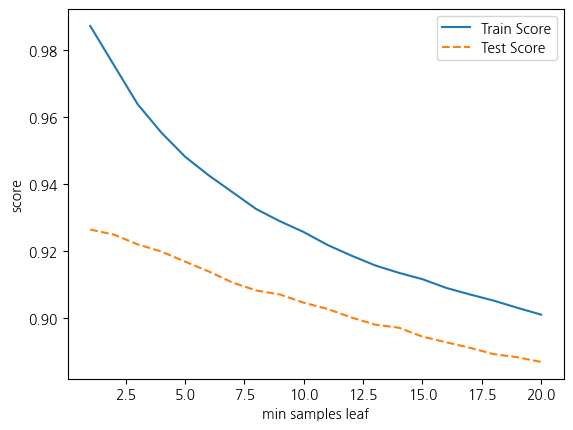

In [81]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()
# min_samples_leaf 5 선택

In [82]:
# min_samples_split
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수 
para_split = [n_split * 2for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(n_estimators = 80, min_samples_leaf = 5,
                               min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.948,0.916
1,6,0.949,0.916
2,8,0.948,0.916
3,10,0.948,0.917
4,12,0.946,0.916
5,14,0.943,0.915
6,16,0.941,0.913
7,18,0.939,0.913
8,20,0.936,0.911
9,22,0.935,0.911


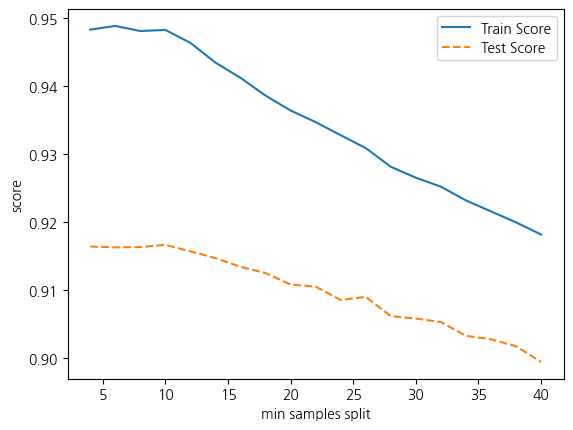

In [83]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()
# min_samples_split 10 선택

In [84]:
# max_depth
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(n_estimators = 80,
                               min_samples_leaf = 5, min_samples_split = 10,
                               max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.511,0.483
1,2,0.680,0.664
2,3,0.778,0.771
3,4,0.830,0.818
4,5,0.872,0.862
5,6,0.898,0.883
6,7,0.915,0.895
7,8,0.927,0.903
8,9,0.936,0.910
9,10,0.941,0.913


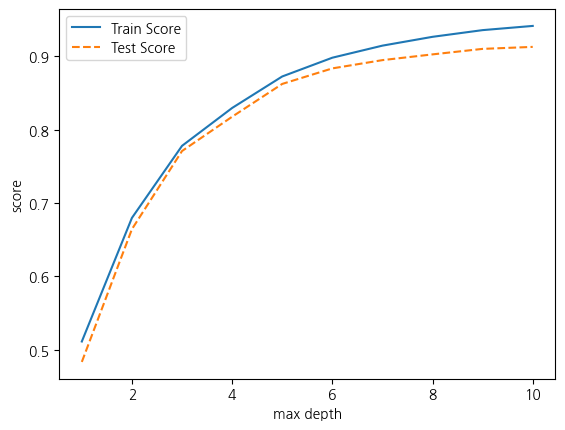

In [85]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

# max_depth 10 선택

In [86]:
# 최종 모델 선정
rf_final = RandomForestRegressor(n_estimators = 80, min_samples_leaf = 5,
                                 min_samples_split = 10, max_depth = 10)
rf_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.942
Score on test set: 0.913


In [117]:
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]
para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]
para_split = [n_split * 2 for n_split in range(2, 21)]
para_depth = [depth for depth in range(1, 11)]

estimator = RandomForestRegressor()

param_grid = {"criterion": ["mse","friedman_mse","mae"], "max_features" : [1.0],
                 "max_depth" : para_depth, "min_samples_split" : para_split, "min_samples_leaf" : para_leaf,
             "n_estimators" : para_n_tree}

grid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model : \n{}".format(grid_dt.best_estimator_))
print("\n best parameter : \n {}".format(grid_dt.best_params_))
print("\n best score : \n {}".format(grid_dt.best_score_.round(3)))

# max_depth=9, max_features=1.0,min_samples_leaf=6, min_samples_split=16

best estimator model : 
RandomForestRegressor(criterion='friedman_mse', max_depth=10,
                      min_samples_leaf=2, min_samples_split=4)

 best parameter : 
 {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}

 best score : 
 0.903


In [87]:
# 변수 중요도
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
11,Power_log,0.681
1,Year,0.235
7,Engine,0.023
6,Mileage,0.013
9,Brand,0.013
2,Kilometers_Driven,0.011
0,Location,0.008
4,Transmission,0.005
10,Size,0.004
3,Fuel_Type,0.003


Text(0, 0.5, '변수')

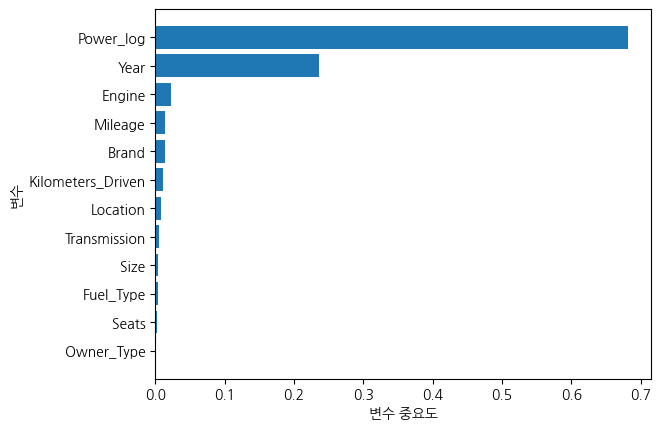

In [88]:
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- GridSearch와 수작업으로 구한 최적의 파라미터 값을 n_estimators = 80, min_samples_leaf = 5, min_samples_split = 10, max_depth = 10으로 설정하였다.
- 최적의 파라미터 값으로 구성한 최종 모델의 성능은 train 0.941 / test 0.916의 설명력을 보였다. 과적합으로 판단되지 않는다.
- 주요 인자를 추출한 결과, Power(최대 출력)이 Price에 가장 큰 영향을 끼치는 것으로 판단된다.
- 또한 Year 또한 Price에 영향을 미치는 2번째 주요 인자로 판단된다.

### GradientBoosting

In [52]:
gb_uncustomized = GradientBoostingRegressor()
gb_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(gb_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.911
Score on test set: 0.931


In [53]:
# 최적 파라미터 튜닝 : n_estimators
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# n_estimators: 트리 수 변경(10~100)
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["Estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

df_score_n.round(3)

,Estimators,TrainScore,TestScore
0,10,0.690,0.702
1,20,0.824,0.845
2,30,0.859,0.884
3,40,0.876,0.901
4,50,0.887,0.910
5,60,0.894,0.917
6,70,0.899,0.923
7,80,0.904,0.926
8,90,0.907,0.929
9,100,0.911,0.932


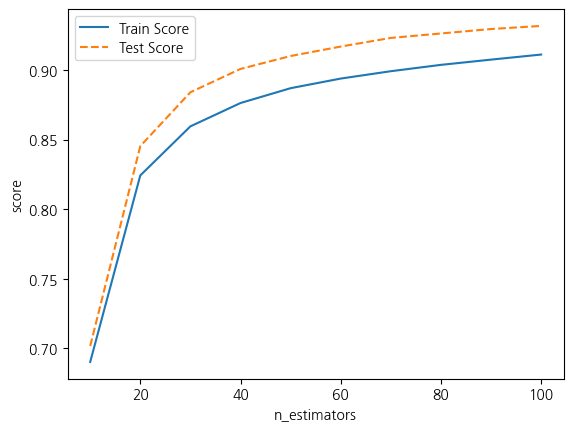

In [54]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()
# n-estimators 100 선택

In [55]:
# min_samples_leaf
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수 
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(n_estimators = 100,
                                   min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.911,0.932
1,2,0.911,0.932
2,3,0.909,0.932
3,4,0.909,0.933
4,5,0.907,0.932
5,6,0.908,0.932
6,7,0.908,0.931
7,8,0.906,0.930
8,9,0.906,0.930
9,10,0.907,0.931


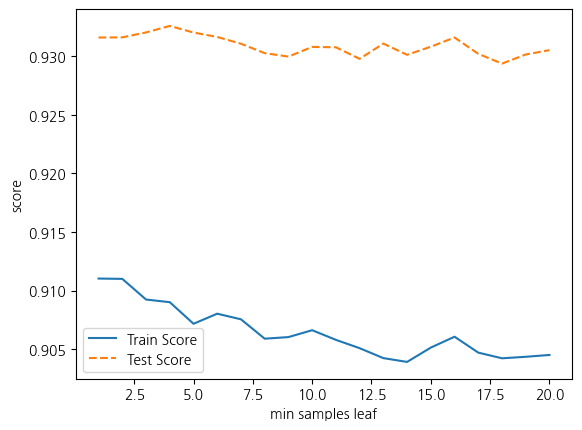

In [56]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()
# min samples leaf 10 선택

In [57]:
# min_samples_split
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(1, 21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 10,
                                   min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.907,0.931
1,4,0.907,0.931
2,6,0.907,0.931
3,8,0.907,0.931
4,10,0.907,0.931
5,12,0.907,0.931
6,14,0.907,0.931
7,16,0.907,0.931
8,18,0.907,0.931
9,20,0.907,0.931


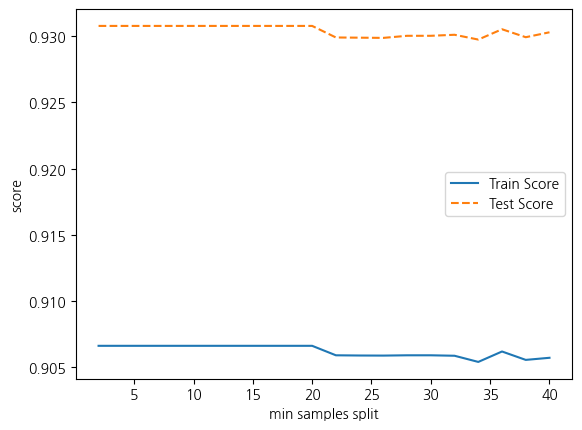

In [58]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()
# 지정X

In [59]:
# max_depth
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 10,
                                   max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.847,0.878
1,2,0.884,0.914
2,3,0.907,0.931
3,4,0.921,0.938
4,5,0.937,0.943
5,6,0.948,0.945
6,7,0.958,0.945
7,8,0.964,0.945
8,9,0.971,0.943
9,10,0.976,0.943


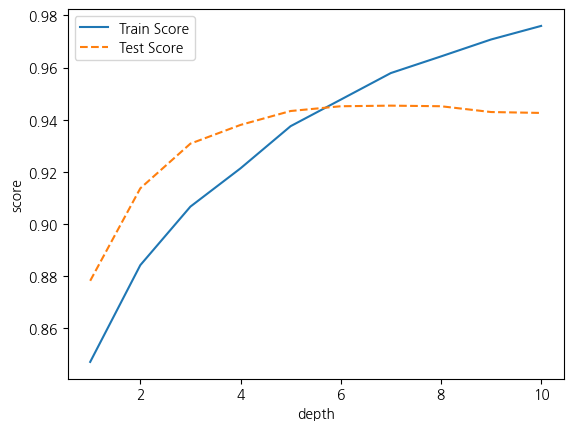

In [60]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("depth")
plt.legend()
# max_depth 6

In [61]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# learning rate: 학습률 변경 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 10,
                                   max_depth = 6, learning_rate = v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score

df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.948,0.945
1,0.2,0.964,0.945
2,0.3,0.974,0.943
3,0.4,0.979,0.937
4,0.5,0.983,0.937
5,0.6,0.987,0.926
6,0.7,0.990,0.916
7,0.8,0.988,0.912
8,0.9,0.991,0.895


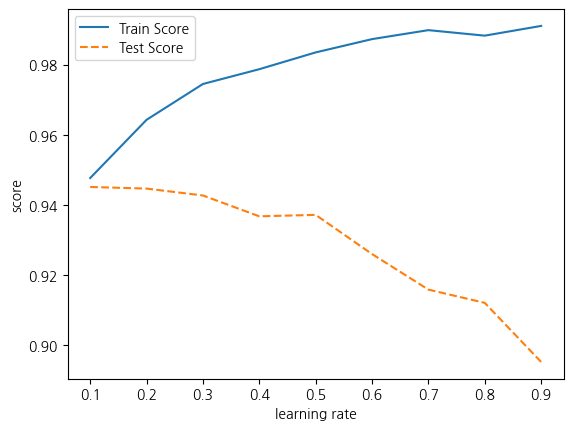

In [62]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_lr, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("learning rate")
plt.legend()
# learning rate 0.1 선택

In [63]:
# 최종모델 선택
gb_final = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 8,
                                     max_depth = 8, learning_rate = 0.1)
gb_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.971
Score on test set: 0.942


In [64]:
# feature_importances_: 설명변수의 중요도
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
10,Power_log,0.637
1,Year,0.227
7,Engine,0.030
2,Kilometers_Driven,0.028
9,Brand,0.021
6,Mileage,0.019
0,Location,0.018
4,Transmission,0.010
3,Fuel_Type,0.005
8,Seats,0.003


Text(0, 0.5, '변수')

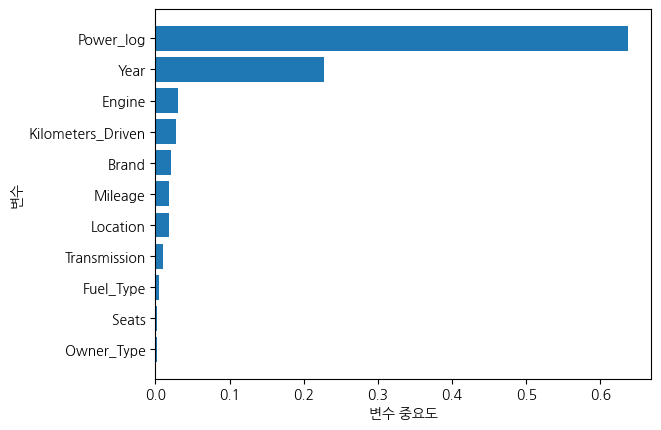

In [65]:
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- GridSearch와 수작업으로 구한 최적의 파라미터 값을 n_estimators = 100, min_samples_leaf = 8, max_depth = 8, learning_rate = 0.1으로 설정하였다.(min_samples_split 지정X)
- 최적의 파라미터 값으로 구성한 최종 모델의 성능은 train 0.971 / test 0.942의 설명력을 보였다. 
- 주요 인자를 추출한 결과, Power(최대 출력)이 Price에 가장 큰 영향을 끼치는 것으로 판단된다.
- 또한 Year 또한 Price에 영향을 미치는 2번째 주요 인자로 판단된다.
- 세 가지 모델에서 추출한 중요인자 모두 Power_log, Year, Engine이 가장 중요한 인자로 판단되었다.

# 4. 모델 평가

In [103]:
# RMSE, MAPE 계산하는 함수 선언
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [104]:
dt_model = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 6, min_samples_split = 14)
dt_model.fit(df_train_x, df_train_y)

rf_model = RandomForestRegressor(n_estimators = 80, min_samples_leaf = 5, 
                                 min_samples_split = 10, max_depth = 10)
rf_model.fit(df_train_x, df_train_y)

gb_model = GradientBoostingRegressor()
gb_model.fit(df_train_x, df_train_y)

GradientBoostingRegressor()

In [105]:
models = ["의사결정나무", "랜덤 포레스트", "그래디언트 부스팅"]

mse, rmse, mae, mape = [],[],[],[]

In [106]:
# DecisionTree 평가 지표 계산
dt_y_pred = dt_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

In [107]:
# RandomForest 평가 지표 계산
rf_y_pred = rf_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

In [108]:
# GradientBoosting 평가 지표 계산
gb_y_pred = gb_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

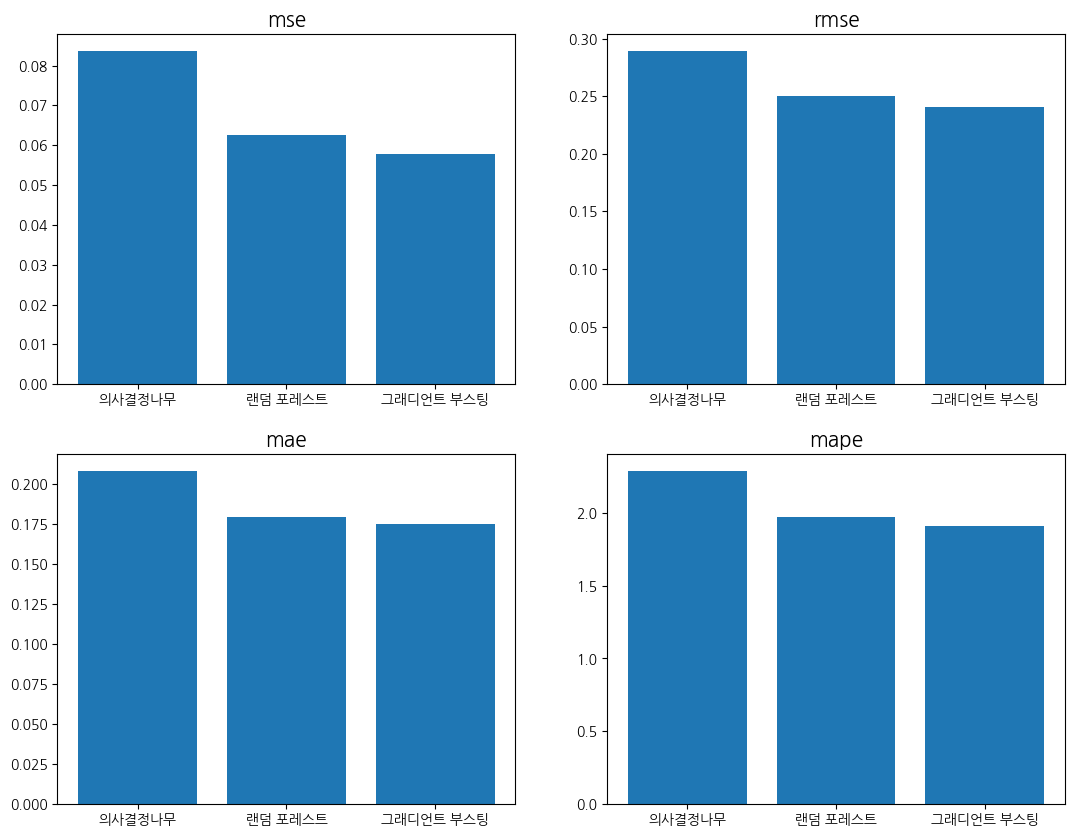

In [109]:
fig, ax = plt.subplots(2,2, figsize = (13, 10))

ax[0,0].bar(models, mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title("mape").set_fontsize(15)

- 모델 평가지표 4가지 모두 GB 모델이 가장 우수한 성능을 보인다. 따라서 예측력이 가장 좋다고 판단되는 GB를 최종 모델로 선정하였다.
- GB :  train 0.971 / test 0.942

## 가설 확인 / 결론 도출
- 도메인 지식을 통해 가설 4개를 세웠다. 그러나 주요 인자를 확인해본 결과, 이 데이터셋에서 가설이 성립하기 어려울 만큼 낮은 중요도를 보였다.
- 따라서 수치형 변수 간 관계, 범주형 변수 간 관계, 수치형 변수들의 유의성과 다중공선성 확인을 위한 선형회귀분석, 연속형 변수간 상관분석, 범주형과 연속형 변수간 ANOVA분석으로 EDA를 마무리 후 모델링을 진행하였다.
- DT, RF, GB의 모델링을 진행 후 가장 성능이 좋은 모델을 결정계수와 여러 성능 지표를 통해 검증한 결과
- n_estimators = 100, min_samples_leaf = 8, max_depth = 8, learning_rate = 0.1의 파라미터를 가지는 GB 모델이 가장 우수하여 최종 모델로 선택하였다. 